In [5]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.append('/home/hpc-rosneft/drigo/surrogate/src/')
sys.path.append('/Users/drigo/ITMO/_disser/surrogate/src/')
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error as mse

from dataset import load_variable_years
from _main import Main
from tools import Logger

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')
from netcdftools import MyNetCDF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
log = Logger(to_file=False, silent=False)
results_df = pd.DataFrame(columns = ['Parameters','Point','dx','dy','dt', 'RMSE_surrogate','RMSE_model'])
ncdf = MyNetCDF(path='data/land-exapmle-int.nc')

results = []
coefficients = []
def rmse(pred, test):
    rmse = np.sqrt(np.nanmean((test - pred)**2))
    #todo - дописать как в статье
    return rmse

def coords_to_point(coords):
    from netcdftools import MyNetCDF
    ncdf = MyNetCDF(path='data/land-exapmle-int.nc')
    return list(ncdf.coords_to_index(coords)[0].data)
    
    
def plotting(pred, y_test, model_data, years_test,title=None):
    
    # plotting settings

    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()

    ax.plot(dates, pred, label='Predictions')
    ax.plot(dates, y_test, label='Measurements',linewidth=2)
    ax.plot(dates, model_data, label = 'NEMO', alpha=0.8)
    
    ax.axhline(y=0, color='grey', linestyle='-')
    fig.legend()
    fig.autofmt_xdate()

    if title is not None: plt.title(title)
    plt.show()
    return plt


def regress(coords, parameters, reg_params, filters=None):
    point = coords_to_point(coords)
    model_data = load_variable_years('icethic_cea', parameters['years_test'], point)
    y_test = load_variable_years(parameters['y_var'], parameters['years_test'], point)
    
    m = Main(parameters=parameters, reg_params=reg_params, logger=log, filters=filters)
    pred = m.predict_point(point)
    
    coefficients.append(m.coeff)
    
    rmse_val_pred = rmse(pred, y_test)
    rmse_val_mod = rmse(model_data, y_test)
    results_df.loc[len(results_df)+1] = [parameters['X_vars'],
                                         coords,
                                     reg_params['dx'],
                                     reg_params['dy'],
                                     reg_params['dt'],
                                     rmse_val_pred,
                                     rmse_val_mod]
    results.append(pred)
    print("RMSE NEMO-measurements: {:.5f}".format(rmse_val_mod))
    print("RMSE DDM-measurements: {:.5f}".format(rmse_val_pred))
    plotting(pred, y_test, model_data, parameters['years_test'], title = '{}N {}E'.format(coords[0], coords[1]))
    

points = [[78,84],[80,-5],[73.6,162],[85,-180]]

# results_df = pd.DataFrame(columns = ['Point','dx','dy','dt', 'RMSE_surrogate','RMSE_model'])
points = [[78,84],[80,-5],[73.6,162],[85,-180]]

from sklearn.linear_model import Lasso, Ridge

Bilding regression with different parameters for 4 points in Arctic ocean:

|Number   | Coordinates  |  Geographical object |
|---|---|---|
|  1 | [78,84]  |  Kara sea |
|  2 | 80,-5  | Fram strait  |
|  3 |  73.6,162 | East Siberian Sea  |
|  4 | 85,-180  |  Open ocean |

<img src="data/map_points.png" alt="map" style="width: 500px;"/>

* No PCA, dx=dy=dt=5
* train on 4 years
* test on 2 years
* all variables

1
2020-01-08 15:19:19	Loading test and train data...
2020-01-08 15:22:41	Data is loaded
[84.45301828]
[74.72704488]
[83.06974301]
[90.88603084]
[72.73380767]
[90.0277658]
[76.43634742]
[77.92552943]
[94.01216307]
[64.87377246]
RMSE NEMO-measurements: 1.27832
RMSE DDM-measurements: 0.57520


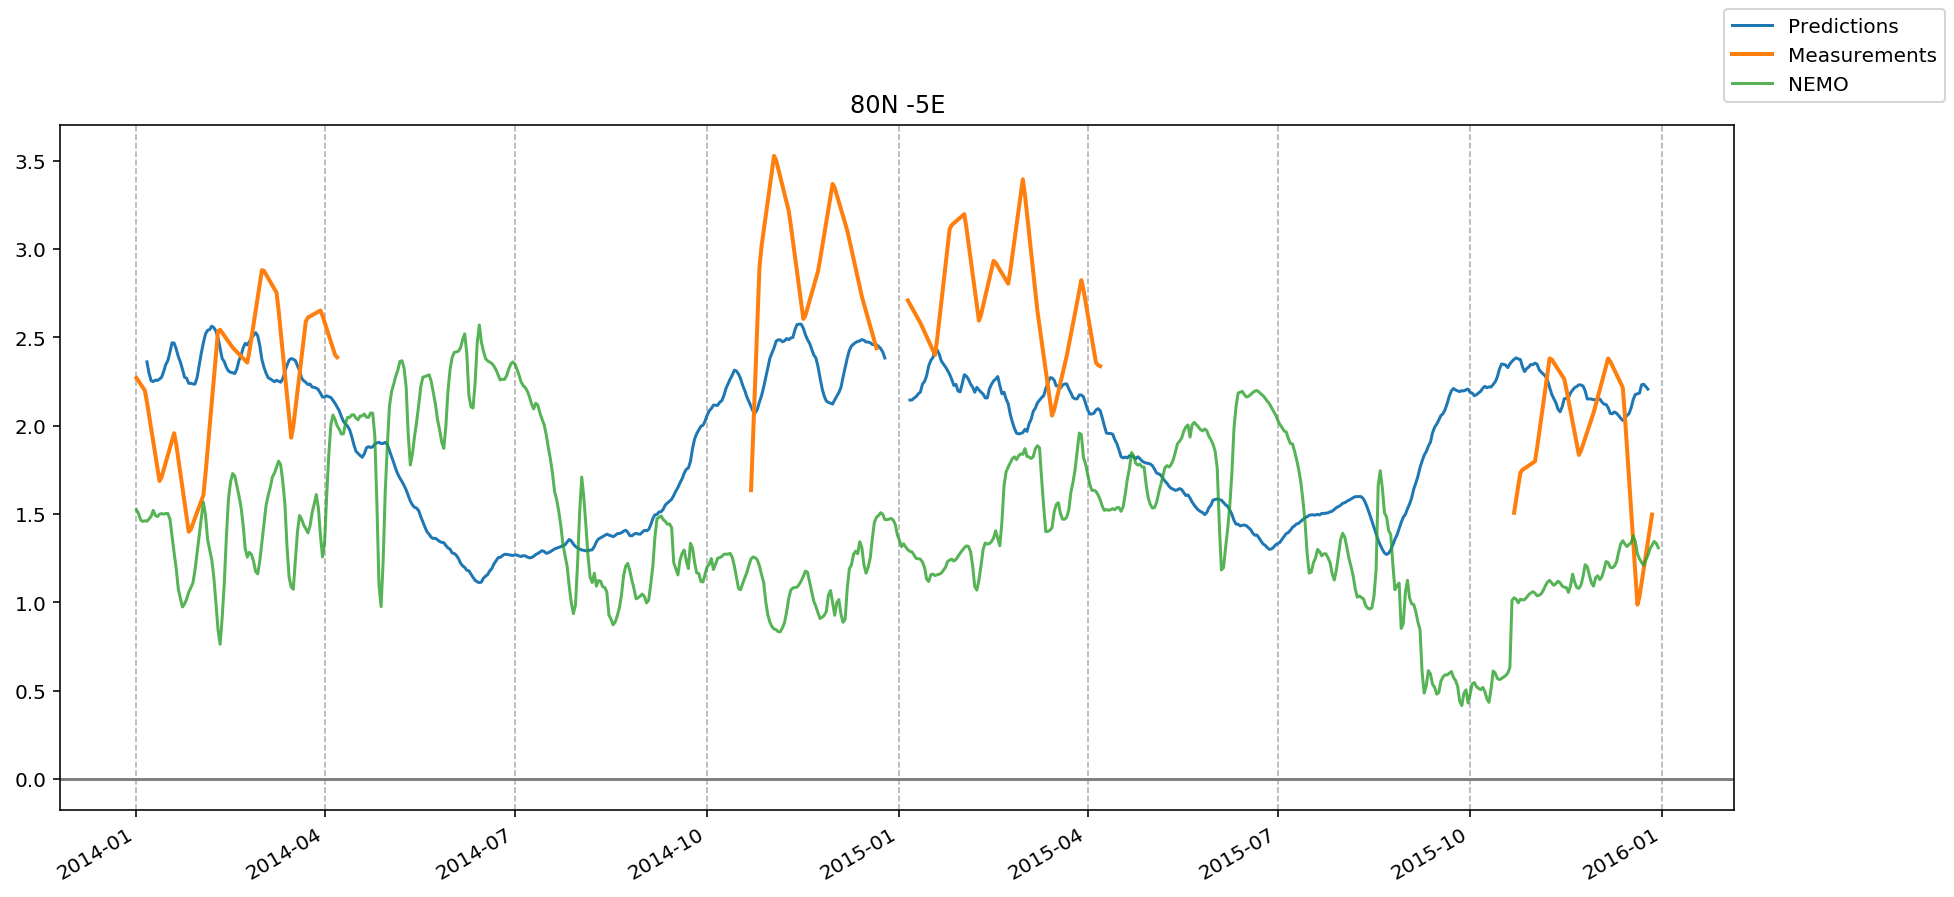

2
2020-01-08 15:22:57	Loading test and train data...
2020-01-08 15:26:08	Data is loaded
[84.45301828 90.11284687]
[74.72704488 80.97296933]
[83.06974301 88.80899954]
[90.88603084 97.29814087]
[72.73380767 80.46991089]
[90.0277658  93.30310214]
[76.43634742 82.02510956]
[77.92552943 87.11332342]
[94.01216307 97.50015437]
[64.87377246 78.25789305]
RMSE NEMO-measurements: 1.27832
RMSE DDM-measurements: 0.54976


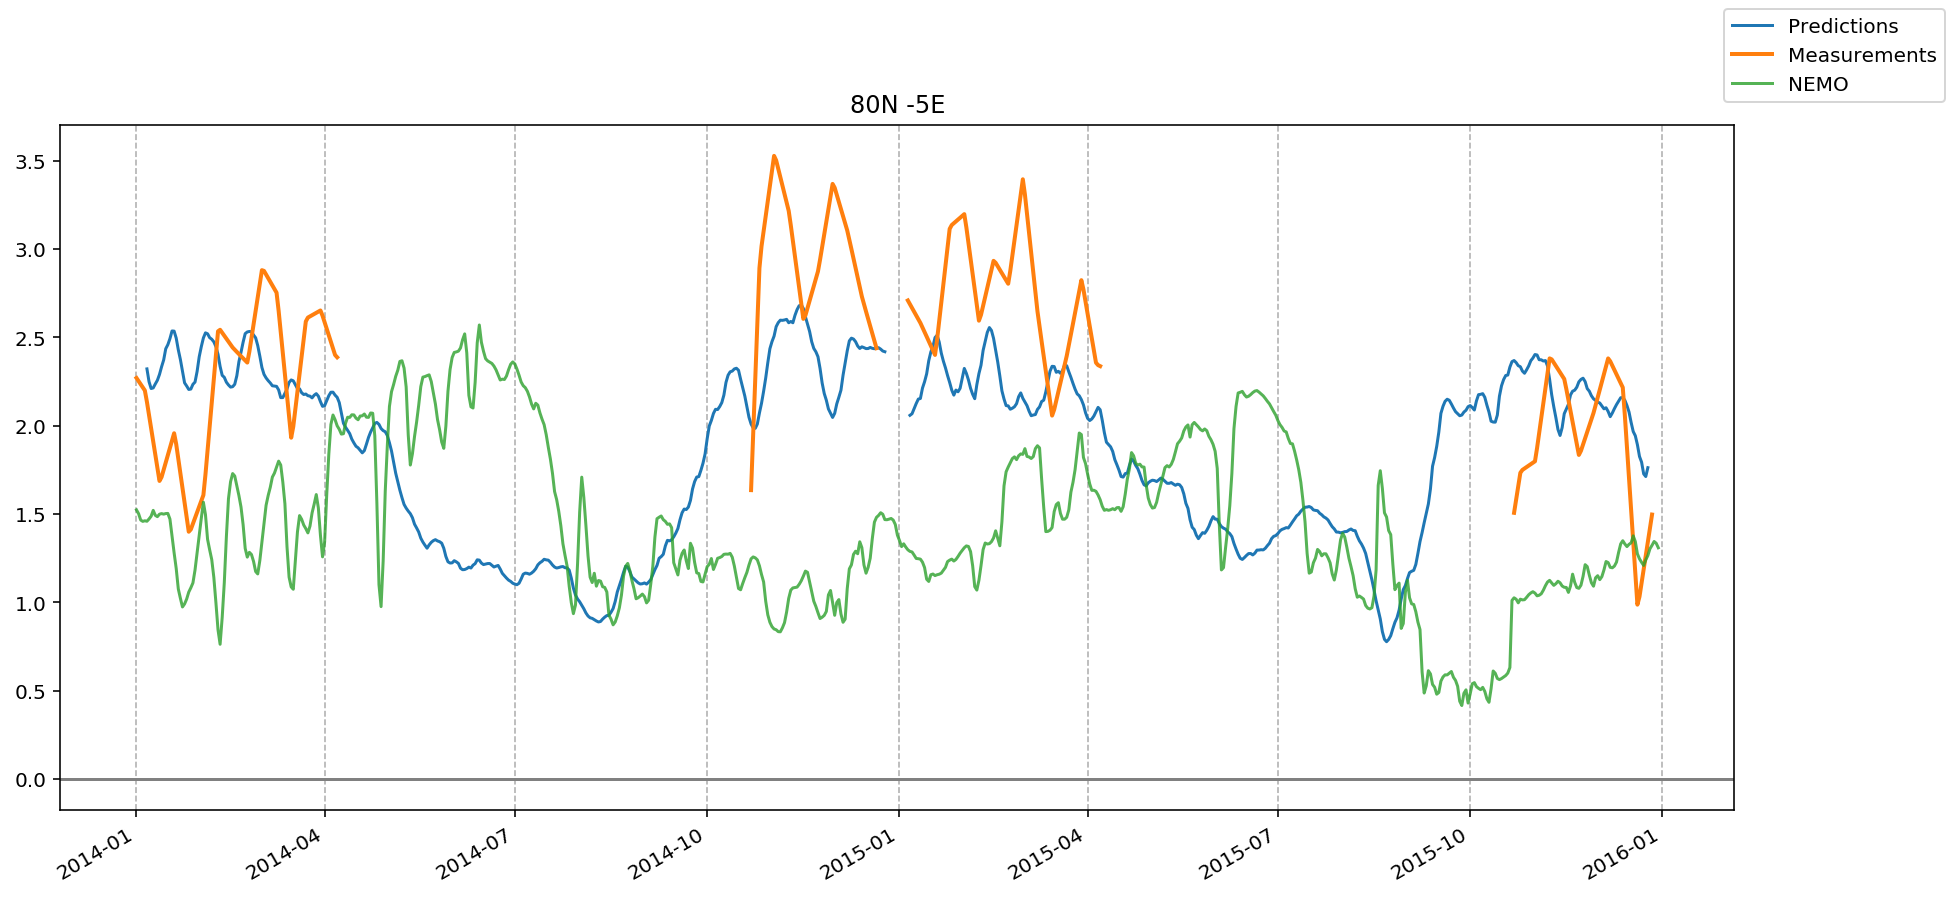

3
2020-01-08 15:26:24	Loading test and train data...
2020-01-08 15:29:34	Data is loaded
[84.45301828 90.11284687 93.36412516]
[74.72704488 80.97296933 85.20879665]
[83.06974301 88.80899954 92.47682265]
[90.88603084 97.29814087 98.44671974]
[72.73380767 80.46991089 85.705073  ]
[90.0277658  93.30310214 95.28032248]
[76.43634742 82.02510956 84.98787711]
[77.92552943 87.11332342 91.80996111]
[94.01216307 97.50015437 98.5601019 ]
[64.87377246 78.25789305 85.03549559]
RMSE NEMO-measurements: 1.27832
RMSE DDM-measurements: 0.56217


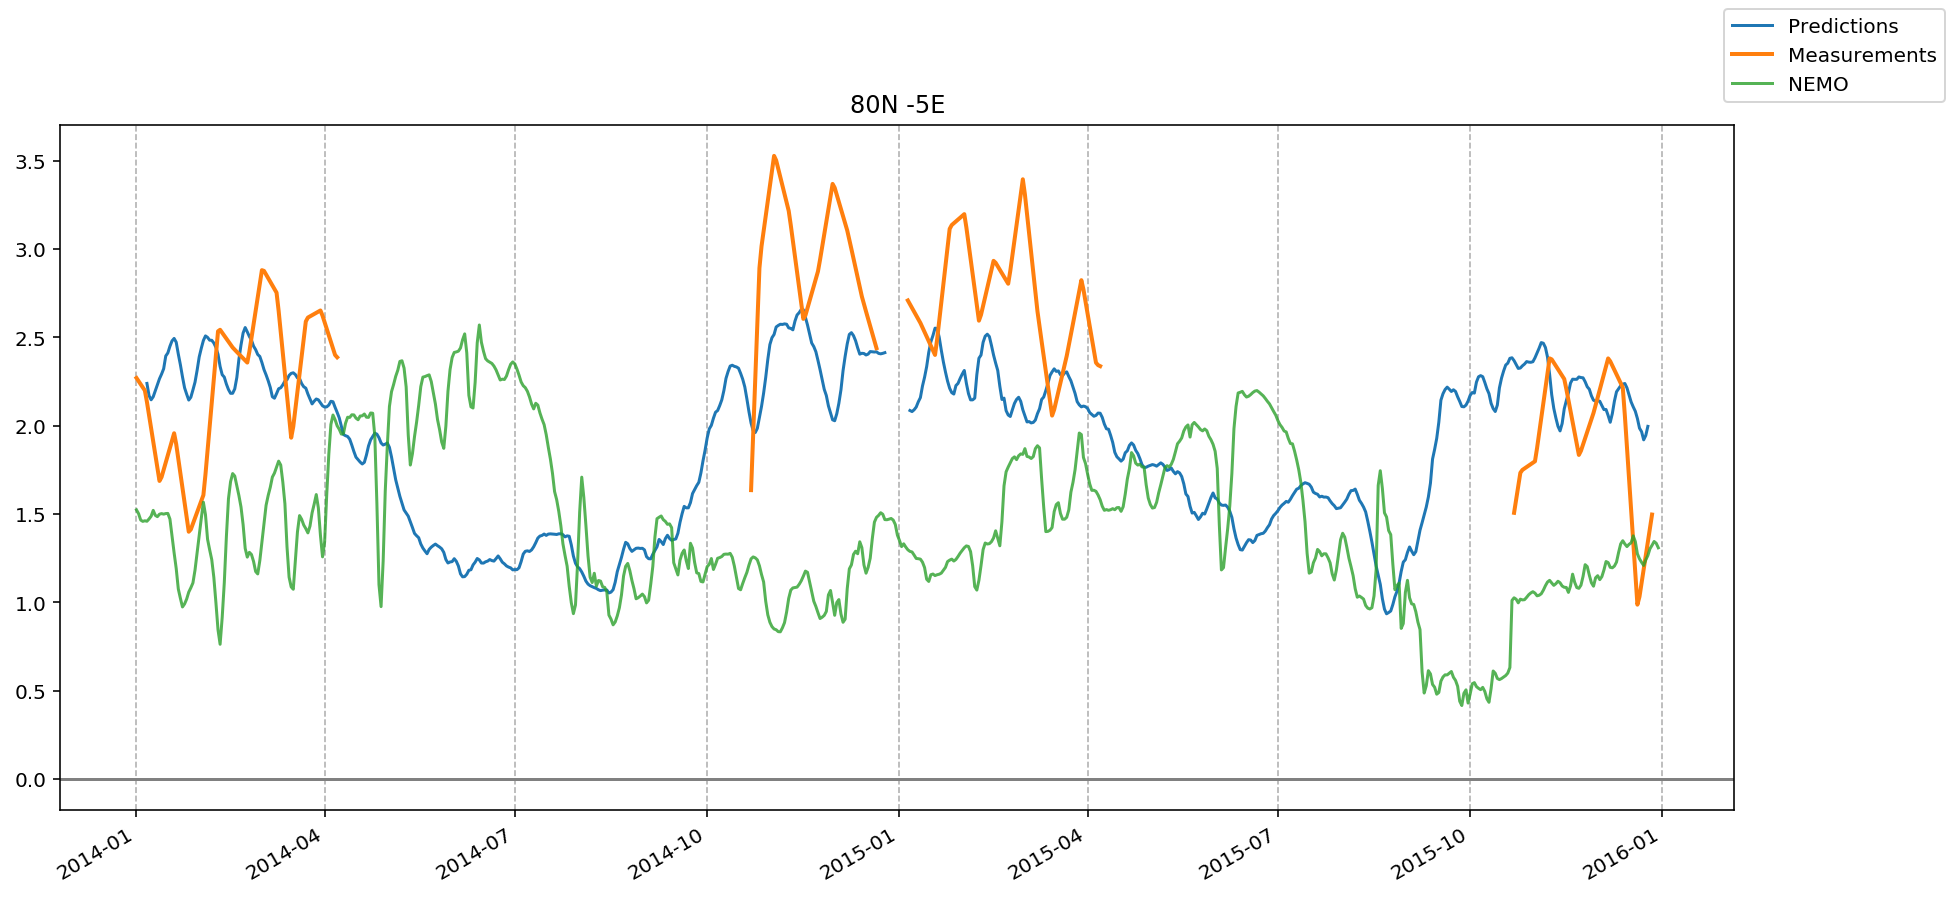

4
2020-01-08 15:29:50	Loading test and train data...
2020-01-08 15:33:01	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466]
[74.72704488 80.97296933 85.20879665 87.9096939 ]
[83.06974301 88.80899954 92.47682265 94.4610695 ]
[90.88603084 97.29814087 98.44671974 99.02729618]
[72.73380767 80.46991089 85.705073   89.24736467]
[90.0277658  93.30310214 95.28032248 96.03878942]
[76.43634742 82.02510956 84.98787711 87.22696923]
[77.92552943 87.11332342 91.80996111 94.02118646]
[94.01216307 97.50015437 98.5601019  99.22951336]
[64.87377246 78.25789305 85.03549559 87.85839101]
RMSE NEMO-measurements: 1.27832
RMSE DDM-measurements: 0.56754


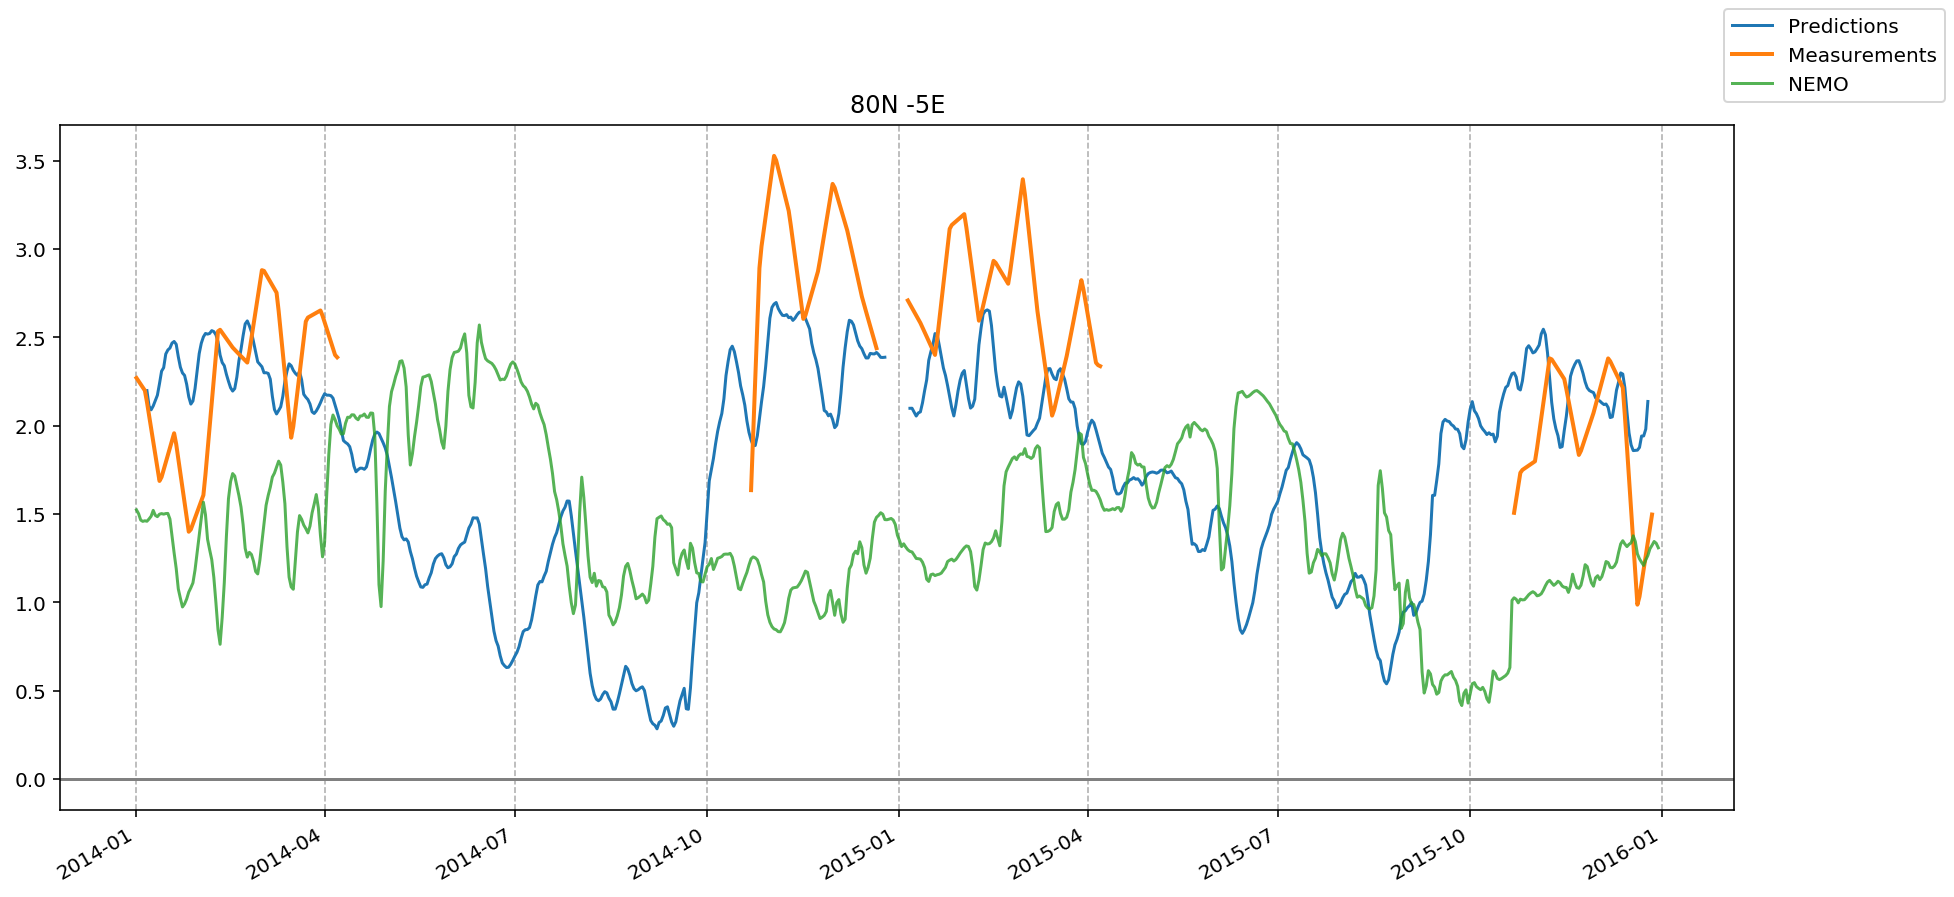

5
2020-01-08 15:33:16	Loading test and train data...
2020-01-08 15:36:26	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232 ]
[72.73380767 80.46991089 85.705073   89.24736467 92.01401934]
[90.0277658  93.30310214 95.28032248 96.03878942 96.53492656]
[76.43634742 82.02510956 84.98787711 87.22696923 89.18299419]
[77.92552943 87.11332342 91.80996111 94.02118646 95.46151973]
[94.01216307 97.50015437 98.5601019  99.22951336 99.46249814]
[64.87377246 78.25789305 85.03549559 87.85839101 90.08573942]
RMSE NEMO-measurements: 1.27832
RMSE DDM-measurements: 0.56692


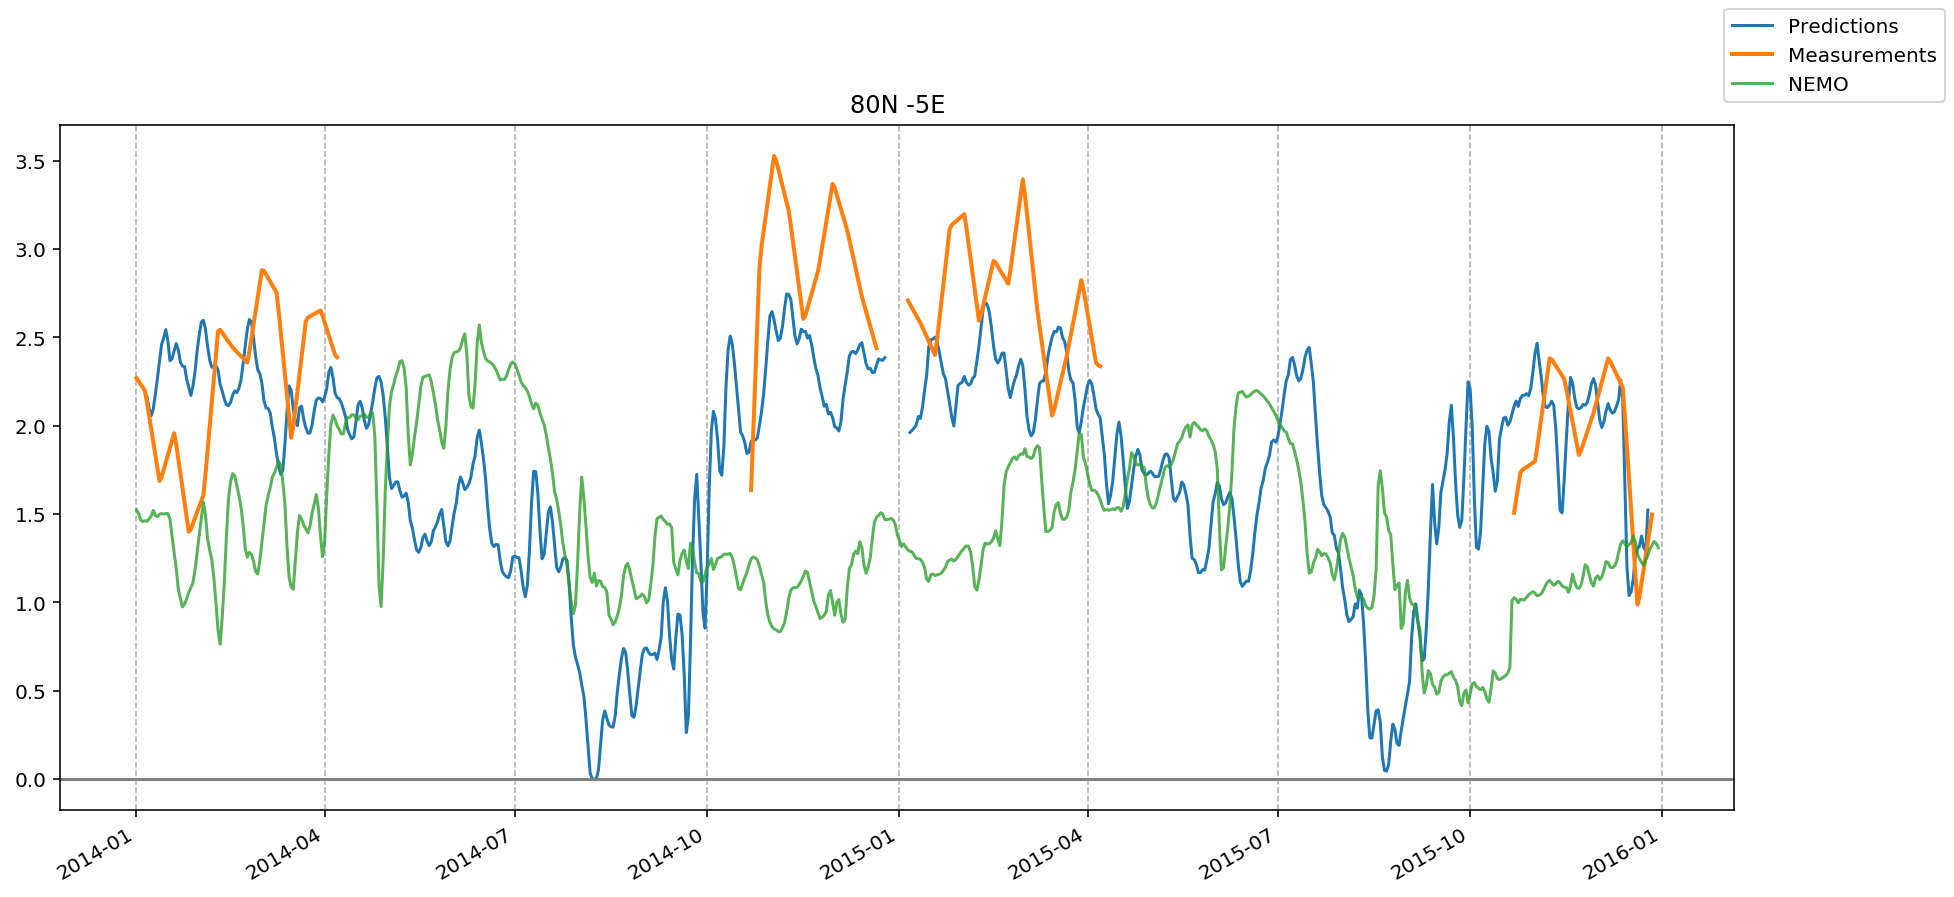

6
2020-01-08 15:36:43	Loading test and train data...
2020-01-08 15:39:53	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099 96.20053507]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337 90.77857636]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683 97.20309114]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232  99.28050015]
[72.73380767 80.46991089 85.705073   89.24736467 92.01401934 93.81412117]
[90.0277658  93.30310214 95.28032248 96.03878942 96.53492656 97.00207289]
[76.43634742 82.02510956 84.98787711 87.22696923 89.18299419 90.58480381]
[77.92552943 87.11332342 91.80996111 94.02118646 95.46151973 96.65331899]
[94.01216307 97.50015437 98.5601019  99.22951336 99.46249814 99.5882657 ]
[64.87377246 78.25789305 85.03549559 87.85839101 90.08573942 92.21103439]
RMSE NEMO-measurements: 1.27832
RMSE DDM-measurements: 0.56213


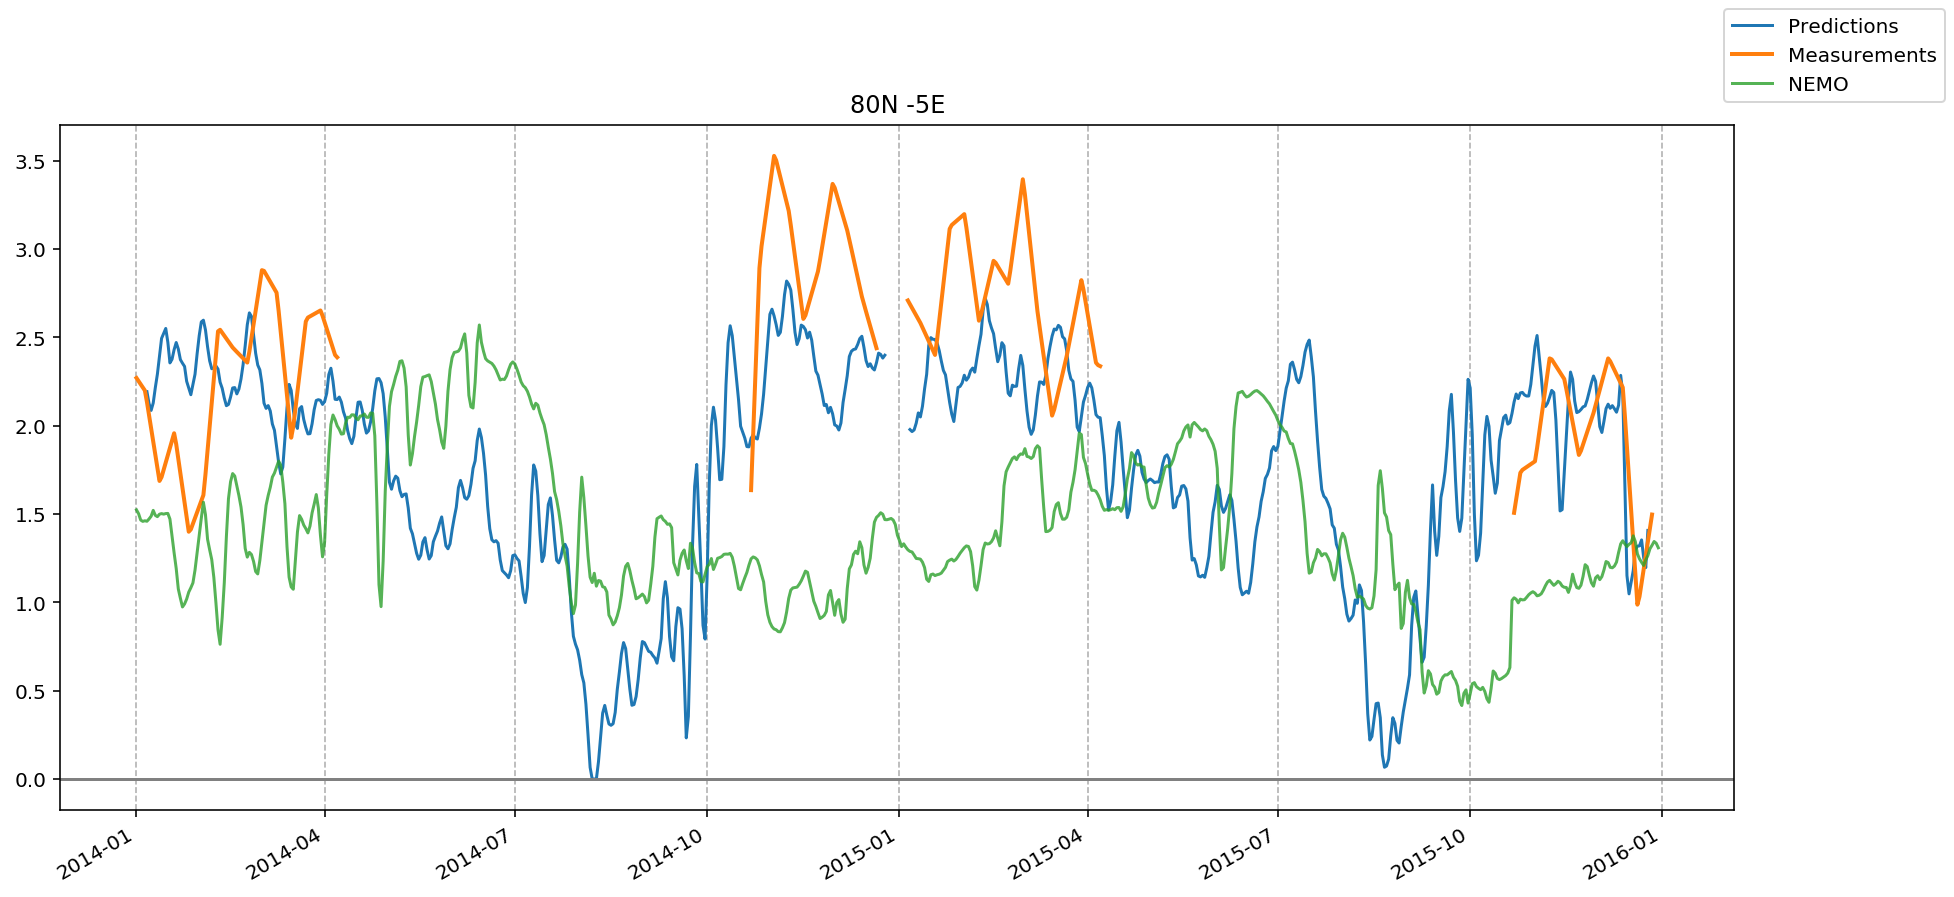

7
2020-01-08 15:40:09	Loading test and train data...
2020-01-08 15:43:20	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099 96.20053507
 96.67980179]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337 90.77857636
 91.80636806]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683 97.20309114
 97.87404934]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232  99.2805002
 99.36624277]
[72.73380767 80.46991089 85.705073   89.24736467 92.01401934 93.81412117
 95.17993561]
[90.0277658  93.30310214 95.28032248 96.03878942 96.53492656 97.00207289
 97.36676283]
[76.43634742 82.02510956 84.98787711 87.22696923 89.18299419 90.58480381
 91.84181319]
[77.92552943 87.11332342 91.80996111 94.02118646 95.46151973 96.65331899
 97.537897  ]
[94.01216307 97.50015437 98.5601019  99.22951336 99.46249814 99.5882657
 99.68287629]
[64.87377246 78.25789305 85.03549559 87.85839101 90.08573942 92.21103439
 93.89705173]
RMSE NEMO-measurements: 1.27832
RMSE DDM-mea

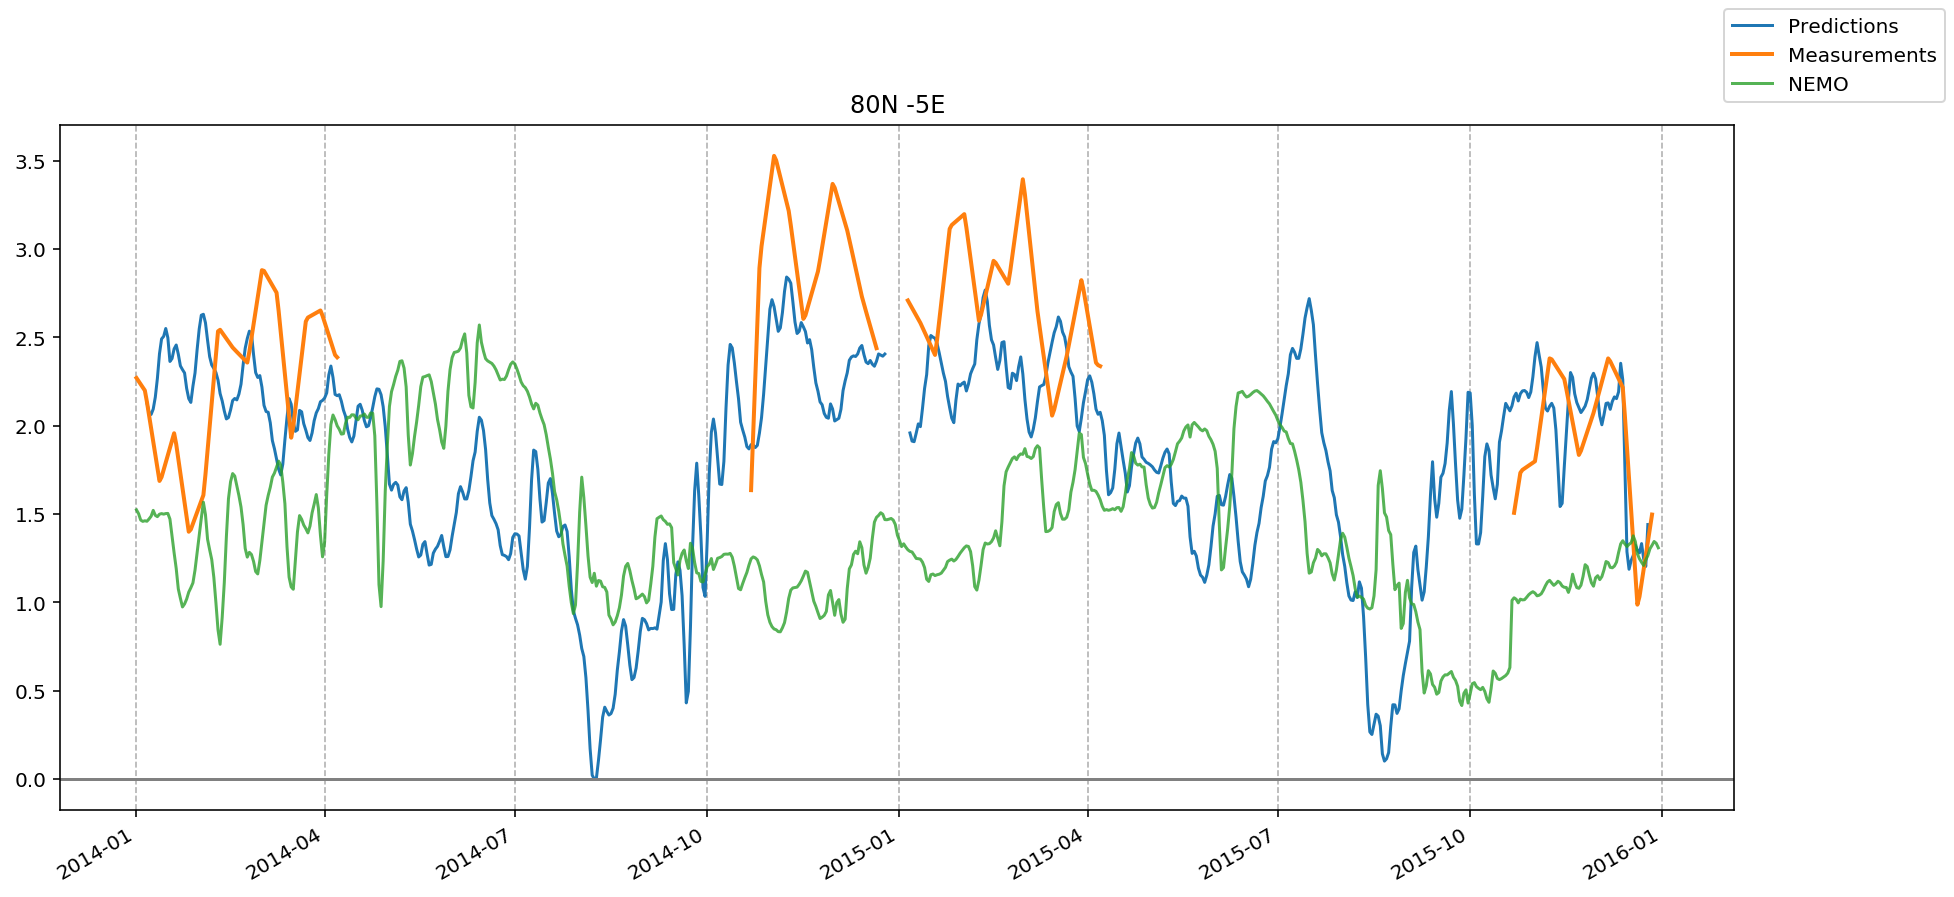

8
2020-01-08 15:43:35	Loading test and train data...
2020-01-08 15:46:46	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099 96.20053507
 96.67980179 97.0952543 ]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337 90.77857636
 91.80636806 92.64416622]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683 97.20309114
 97.87404934 98.33774099]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232  99.2805002
 99.36624277 99.4477519 ]
[72.73380767 80.46991089 85.705073   89.24736467 92.01401934 93.81412117
 95.17993561 96.3257045 ]
[90.0277658  93.30310214 95.28032248 96.03878942 96.53492656 97.00207289
 97.36676283 97.69723684]
[76.43634742 82.02510956 84.98787711 87.22696923 89.18299419 90.58480381
 91.84181319 92.85158866]
[77.92552943 87.11332342 91.80996111 94.02118646 95.46151973 96.65331899
 97.537897   98.21394049]
[94.01216307 97.50015437 98.5601019  99.22951336 99.46249814 99.5882657
 99.68287629 99.74701961]
[64.87377246 78.2578930

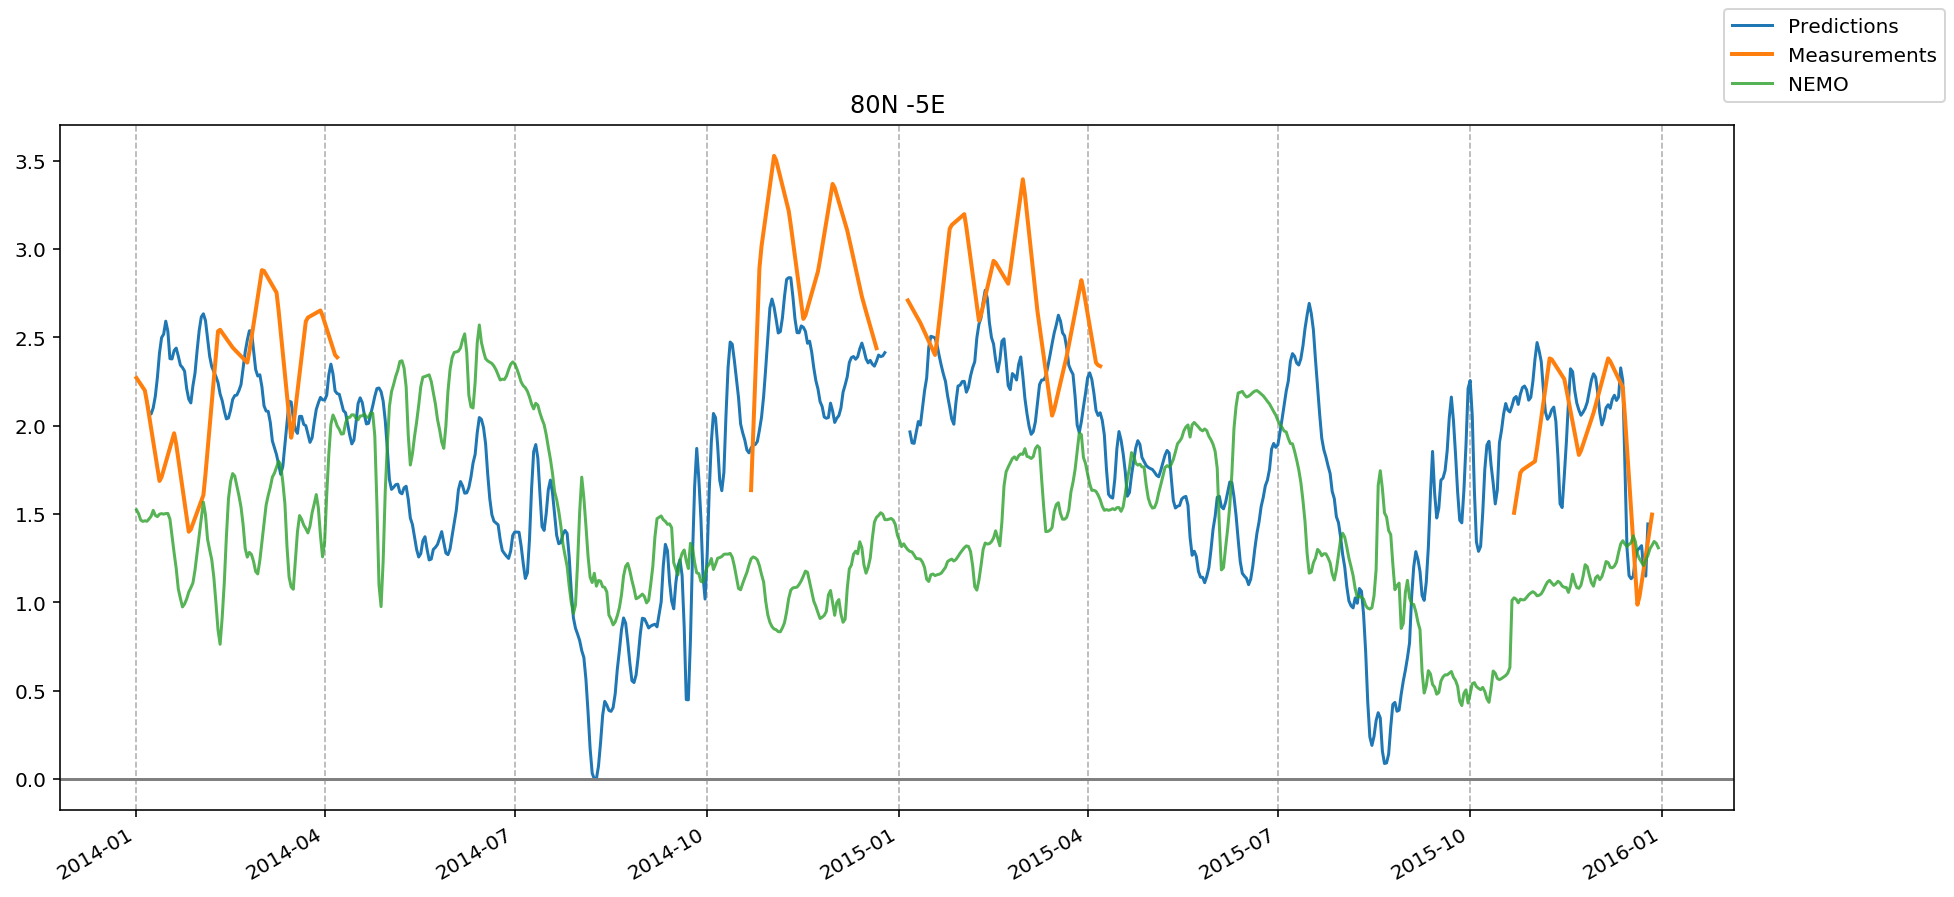

9
2020-01-08 15:47:01	Loading test and train data...
2020-01-08 15:50:11	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099 96.20053507
 96.67980179 97.0952543  97.3962791 ]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337 90.77857636
 91.80636806 92.64416622 93.30818388]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683 97.20309114
 97.87404934 98.33774099 98.66827445]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232  99.2805002
 99.36624277 99.4477519  99.50384669]
[72.73380767 80.46991089 85.705073   89.24736467 92.01401934 93.81412117
 95.17993561 96.3257045  97.1281465 ]
[90.0277658  93.30310214 95.28032248 96.03878942 96.53492656 97.00207289
 97.36676283 97.69723684 97.93554753]
[76.43634742 82.02510956 84.98787711 87.22696923 89.18299419 90.58480381
 91.84181319 92.85158866 93.6786962 ]
[77.92552943 87.11332342 91.80996111 94.02118646 95.46151973 96.65331899
 97.537897   98.21394049 98.69830962]
[94.01216307 97.50015437 

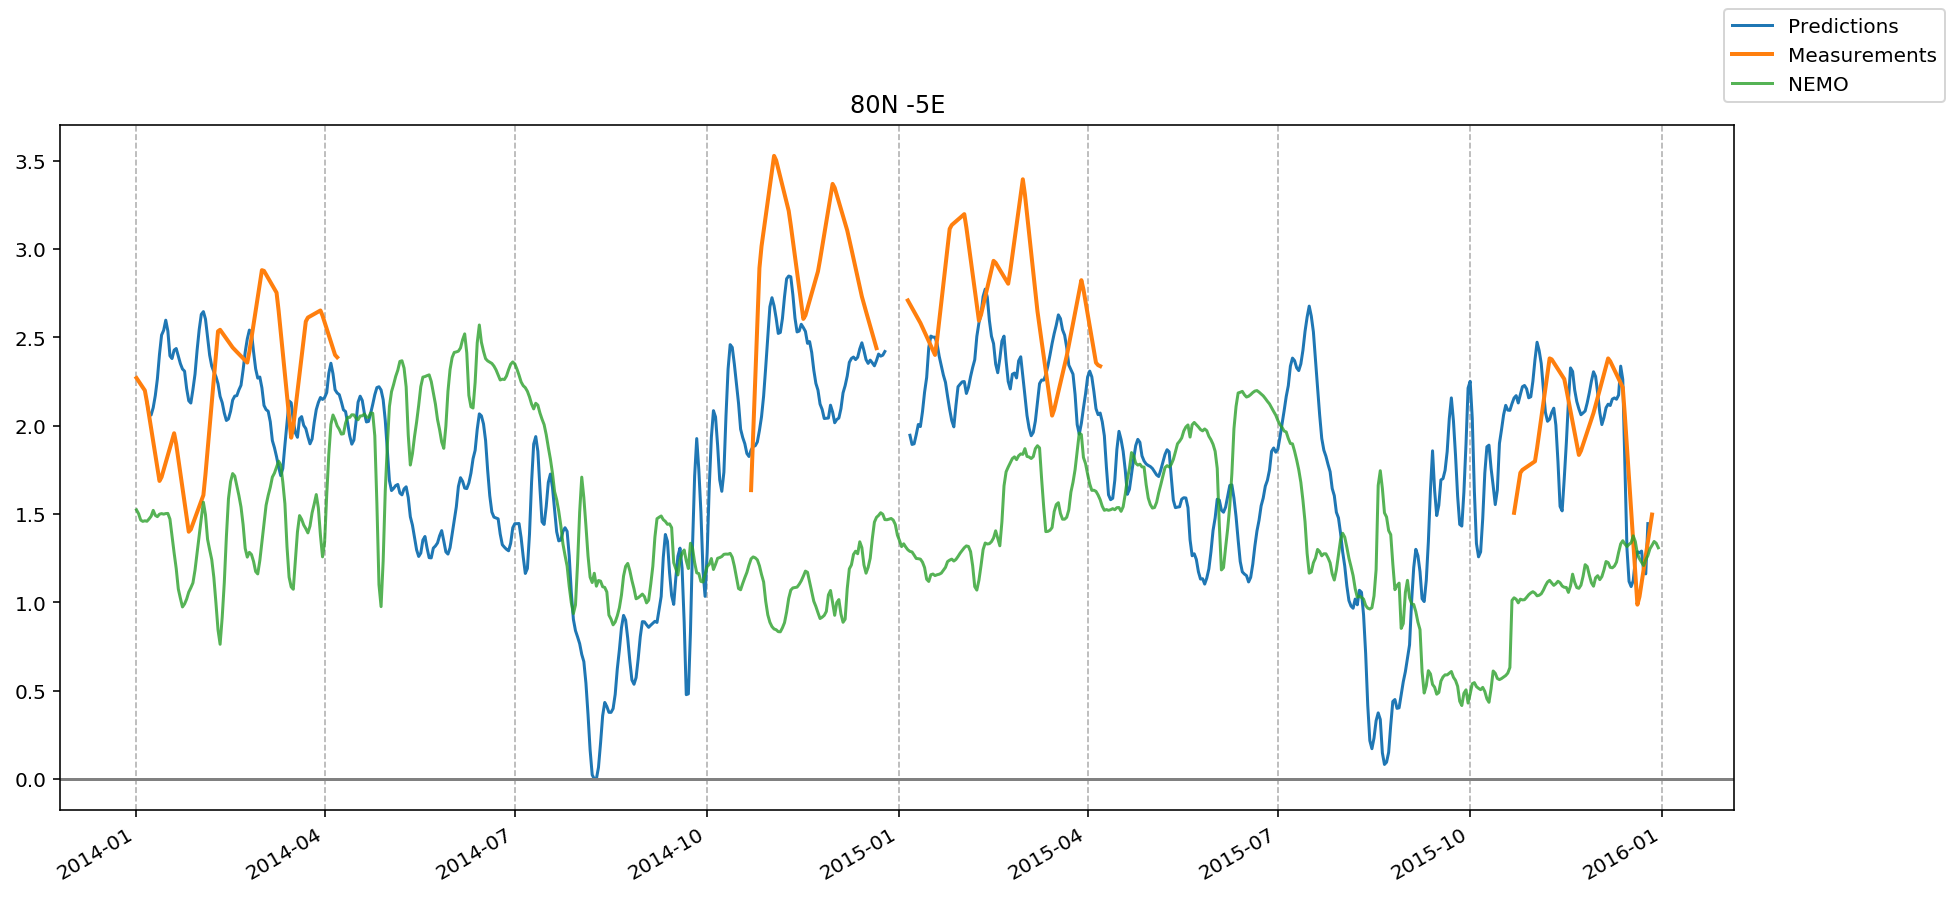

10
2020-01-08 15:50:27	Loading test and train data...
2020-01-08 15:53:38	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099 96.20053507
 96.67980179 97.0952543  97.3962791  97.64786648]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337 90.77857636
 91.80636806 92.64416622 93.30818388 93.87573702]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683 97.20309114
 97.87404934 98.33774099 98.66827445 98.97072913]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232  99.2805002
 99.36624277 99.4477519  99.50384669 99.55348812]
[72.73380767 80.46991089 85.705073   89.24736467 92.01401934 93.81412117
 95.17993561 96.3257045  97.1281465  97.71069755]
[90.0277658  93.30310214 95.28032248 96.03878942 96.53492656 97.00207289
 97.36676283 97.69723684 97.93554753 98.14953634]
[76.43634742 82.02510956 84.98787711 87.22696923 89.18299419 90.58480381
 91.84181319 92.85158866 93.6786962  94.34158028]
[77.92552943 87.11332342 91.80996111 94.02118646 95

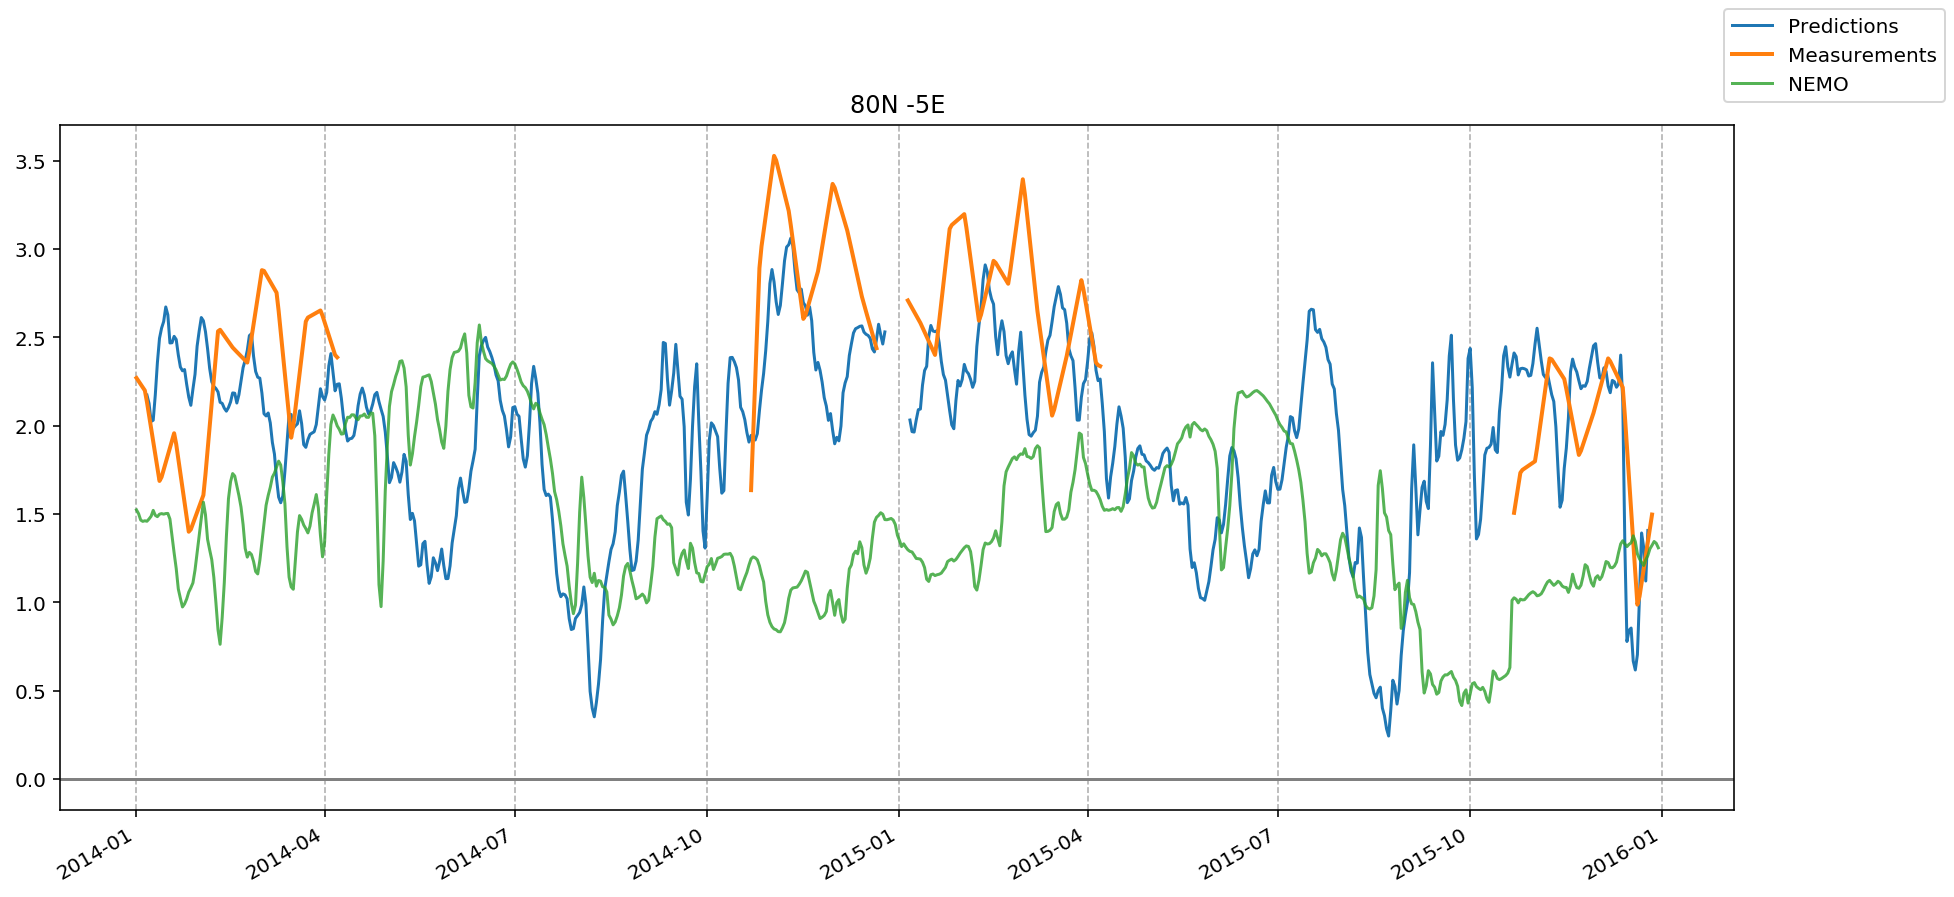

CPU times: user 3min 10s, sys: 4min 8s, total: 7min 18s
Wall time: 34min 42s


In [44]:
%%time

for i in range(1,11):
    print(i)
    parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=list(range(2014, 2016)),
                  X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw'],
                  #X_vars=['ice_conc','icethic_cea', 'votemper','vosaline'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

    reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )
    filters = dict(partial_pca=10)
    regress(points[1], parameters, reg_params, filters)

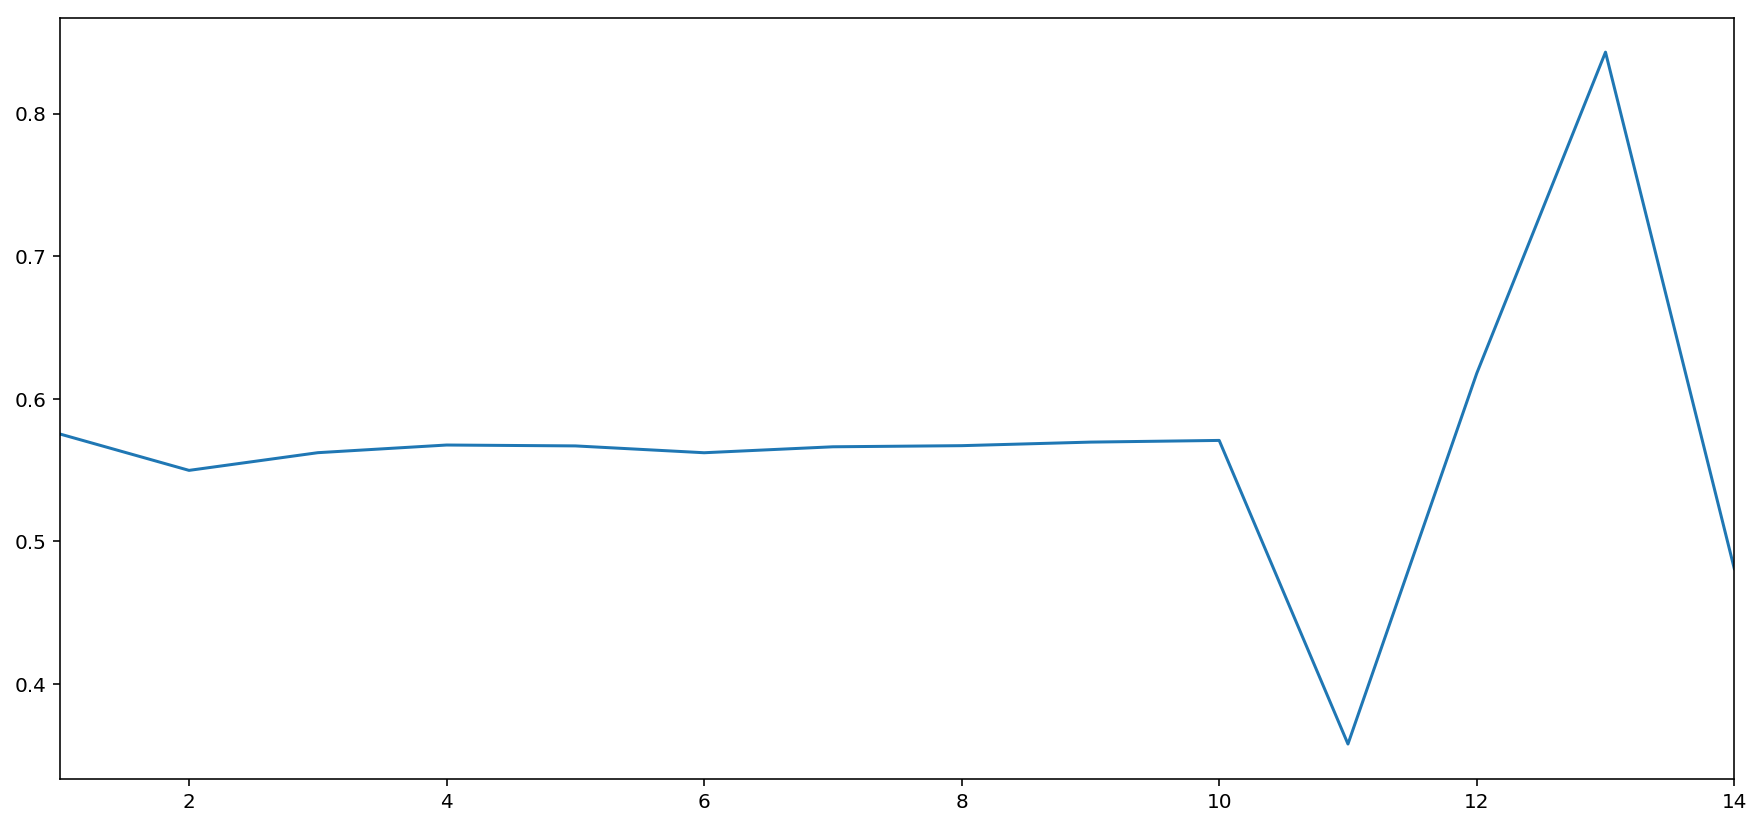

In [46]:
results_df.RMSE_surrogate.plot()

In [2]:
variance = [[84.45301828,90.11284687, 93.36412516, 94.70677466, 95.55119099, 96.20053507, 96.67980179, 97.0952543, 97.3962791,97.64786648],
[74.72704488, 80.97296933, 85.20879665, 87.9096939,  89.52583337, 90.77857636, 91.80636806, 92.64416622, 93.30818388, 93.87573702],
[83.06974301, 88.80899954, 92.47682265, 94.4610695,  96.03103683, 97.20309114, 97.87404934, 98.33774099, 98.66827445, 98.97072913],
[90.88603084, 97.29814087, 98.44671974, 99.02729618, 99.1784232,  99.2805002, 99.36624277, 99.4477519,  99.50384669, 99.55348812],
[72.73380767, 80.46991089, 85.705073,   89.24736467, 92.01401934, 93.81412117, 95.17993561, 96.3257045,  97.1281465,  97.71069755],
[90.0277658,  93.30310214, 95.28032248, 96.03878942, 96.53492656, 97.00207289, 97.36676283, 97.69723684, 97.93554753, 98.14953634],
[76.43634742, 82.02510956, 84.98787711, 87.22696923, 89.18299419, 90.58480381, 91.84181319, 92.85158866, 93.6786962,  94.34158028],
[77.92552943, 87.11332342, 91.80996111, 94.02118646, 95.46151973, 96.6533189, 97.537897,   98.21394049, 98.69830962, 98.98424546],
[94.01216307, 97.50015437, 98.5601019,  99.22951336, 99.46249814, 99.5882657, 99.68287629, 99.74701961, 99.794371,   99.82388595],
[64.87377246, 78.25789305, 85.03549559, 87.85839101, 90.08573942, 92.21103439, 93.89705173, 95.3320928,  96.3053554,  97.0006309 ]]

Text(0, 0.5, 'Explained variance ratio, %')

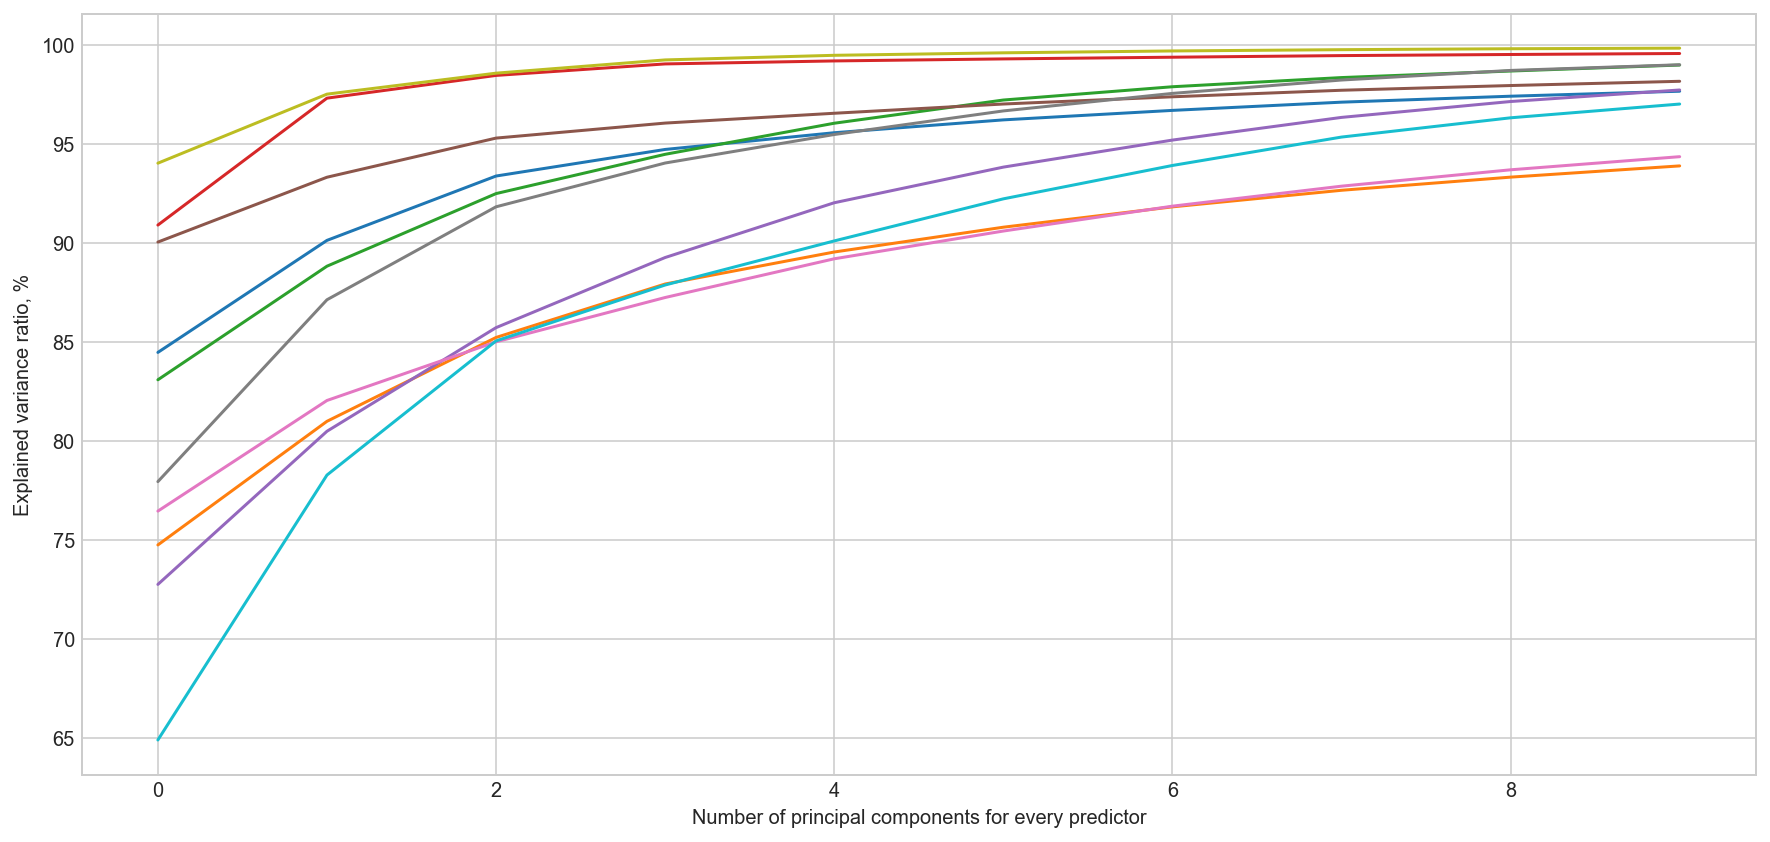

In [11]:
for row in variance:
    plt.plot(row)
plt.xlabel('Number of principal components for every predictor')
plt.ylabel('Explained variance ratio, %')


In [39]:
x_ax = range(len(m.coeff))
plt.plot(x_ax,m.coeff,'bo')
k = len(m.coeff)/len(parameters['X_vars'])
xcoords = np.arange(0,len(m.coeff),k)
xcoords = xcoords-0.5
for xc in xcoords:
        plt.axvline(x=xc)   

NameError: name 'm' is not defined

In [6]:
import pickle
with open('coeff.pkl', 'rb') as f:
    coefficients = pickle.load(f)

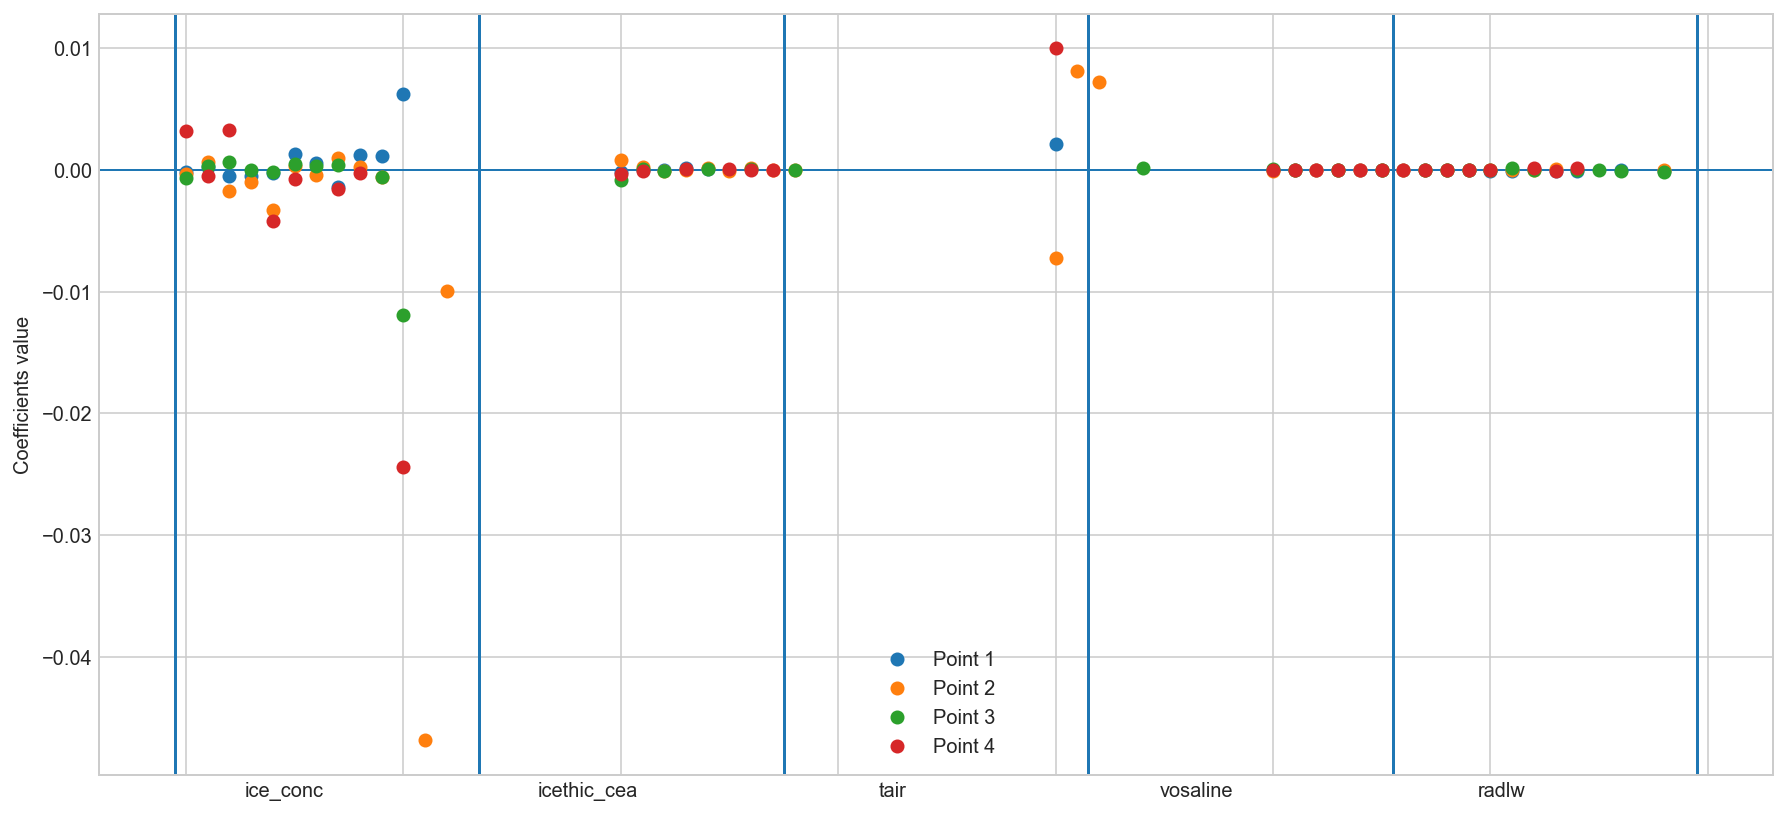

In [10]:
import matplotlib.ticker as ticker

parameters = dict(years_train=list(range(2010, 2014)),
              years_test=list(range(2014, 2016)),
              X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw'],
              #X_vars=['ice_conc','icethic_cea', 'votemper','vosaline'],
              y_var='thick_cr2smos',
              bounds=[0, 400, 0, 400],
              step=[1, 1]
              )

coef = coefficients[0]
ax = plt.gca()
k = len(coef)/len(parameters['X_vars'])
xcoords = np.arange(0,len(coef)+1,k)
xcoords = xcoords-0.5

ax.axhline(y=0,linewidth=1, linestyle='-')
for i, xc in enumerate(xcoords):
    ax.axvline(x=xc)

ax.set_xticklabels('')
ax.set_xticks(xcoords+5,minor=True)
ax.set_xticklabels(parameters['X_vars'], minor=True)

for i, coef in enumerate(coefficients):
    coef[coef==0]=np.nan
    ax.plot(coef,'o', label = f'Point {i+1}')
plt.ylabel('Coefficients value')
plt.legend()

2020-01-21 19:16:36	Loading test and train data...
2020-01-21 19:19:35	Data is loaded
[94.65749009 96.55974912 97.73475555 98.43987927 98.73898447 98.9052928
 99.05390797 99.19542146 99.30653707 99.39264399 99.45917845 99.51181549
 99.55835048 99.59800083 99.63181665 99.6607988  99.68822402 99.71001382
 99.72942615 99.74706874]
[84.91955565 87.82205294 89.84142024 91.17021454 92.06169046 92.88170607
 93.40726273 93.82012945 94.20443283 94.4798968  94.72111349 94.94191068
 95.14435045 95.33909361 95.50083978 95.65286895 95.7936575  95.92406726
 96.05089671 96.16766116]
[88.02530849 92.21119048 94.44561533 95.9237749  97.05195268 97.83631248
 98.40571733 98.8267501  99.1123143  99.31996921 99.49485044 99.66098711
 99.7229242  99.76017319 99.78951353 99.81524063 99.83663123 99.85596232
 99.87227953 99.88688285]
[93.10860173 96.27082731 98.09547959 98.69233362 98.86848161 98.98897112
 99.09242135 99.19128501 99.28756043 99.38224379 99.47624867 99.56983292
 99.66302833 99.75610739 99.828612

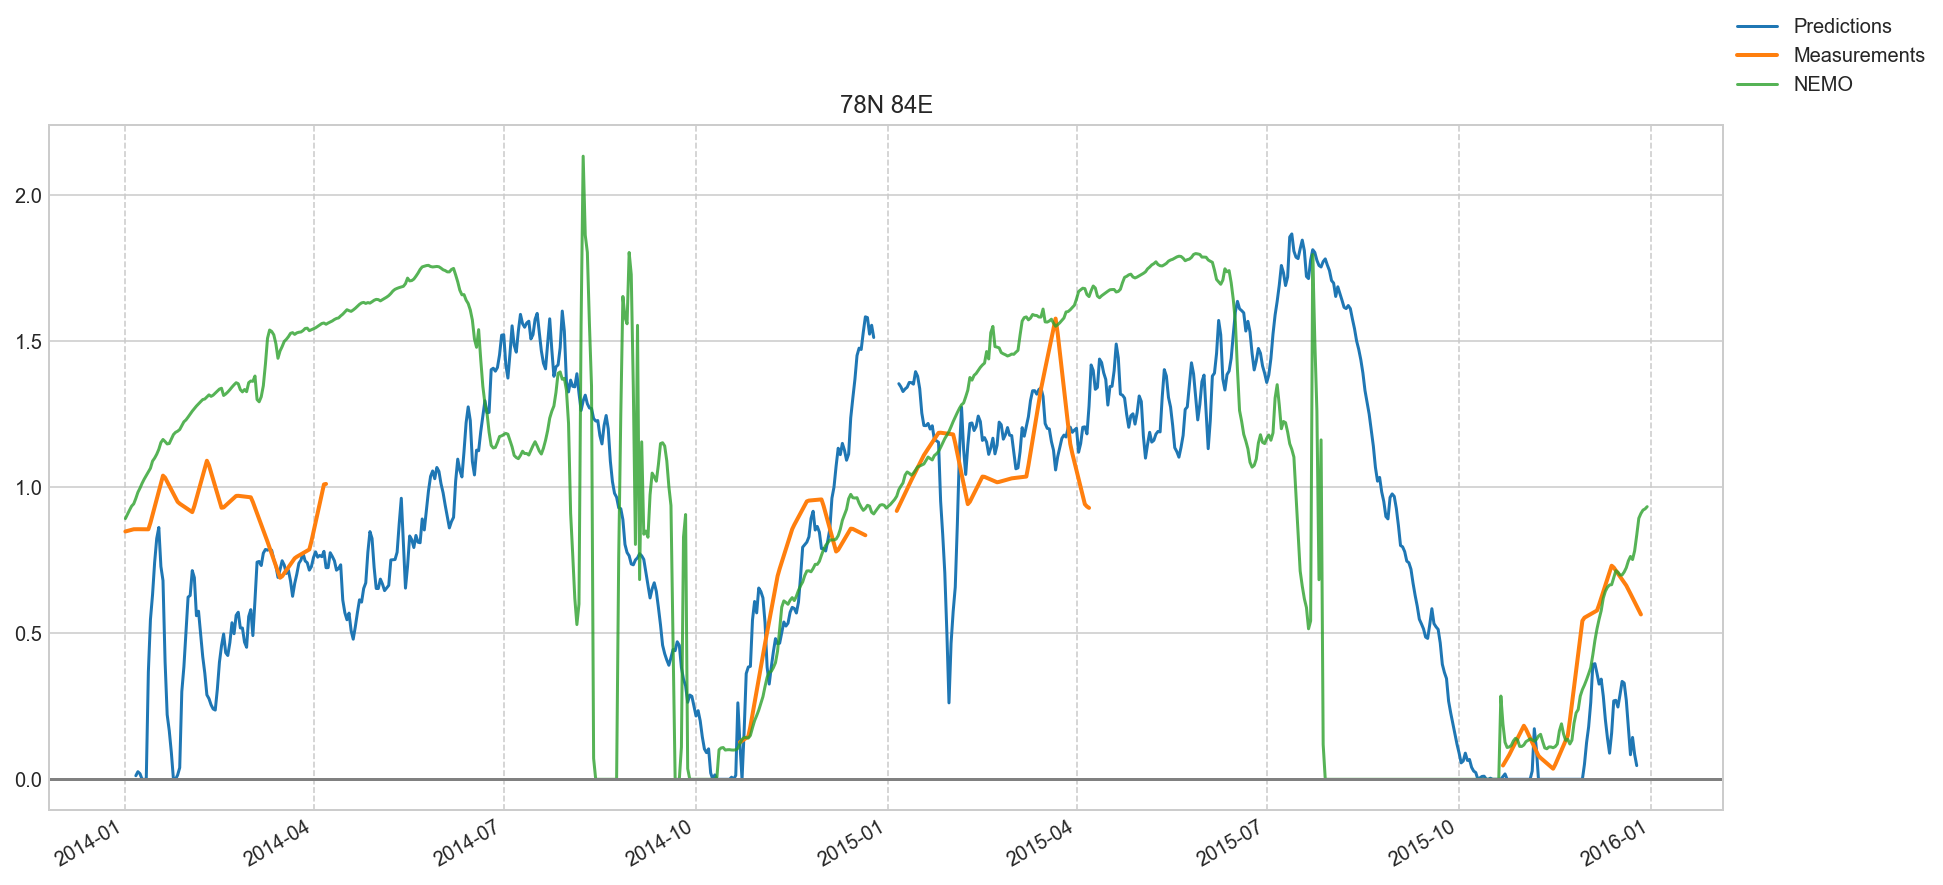

2020-01-21 19:19:51	Loading test and train data...
2020-01-21 19:23:04	Data is loaded
[84.45301828 90.11284687 93.36412516 94.70677466 95.55119099 96.20053507
 96.67980179 97.0952543  97.3962791  97.64786648 97.84118189 98.01656228
 98.17728075 98.31306696 98.43377259 98.54762987 98.63693255 98.72427872
 98.80159423 98.87276824]
[74.72704488 80.97296933 85.20879665 87.9096939  89.52583337 90.77857636
 91.80636806 92.64416622 93.30818388 93.87573702 94.31674783 94.70851651
 95.07443972 95.40291805 95.71767655 95.99171711 96.25285201 96.45754593
 96.63679621 96.80745161]
[83.06974301 88.80899954 92.47682265 94.4610695  96.03103683 97.20309114
 97.87404934 98.33774099 98.66827445 98.97072913 99.24192384 99.43609372
 99.51502761 99.58322391 99.64029456 99.68612564 99.72053785 99.75074176
 99.77780766 99.8011907 ]
[90.88603084 97.29814087 98.44671974 99.02729618 99.1784232  99.2805002
 99.36624277 99.4477519  99.50384669 99.55348812 99.60030637 99.64251516
 99.68333627 99.72399578 99.764422

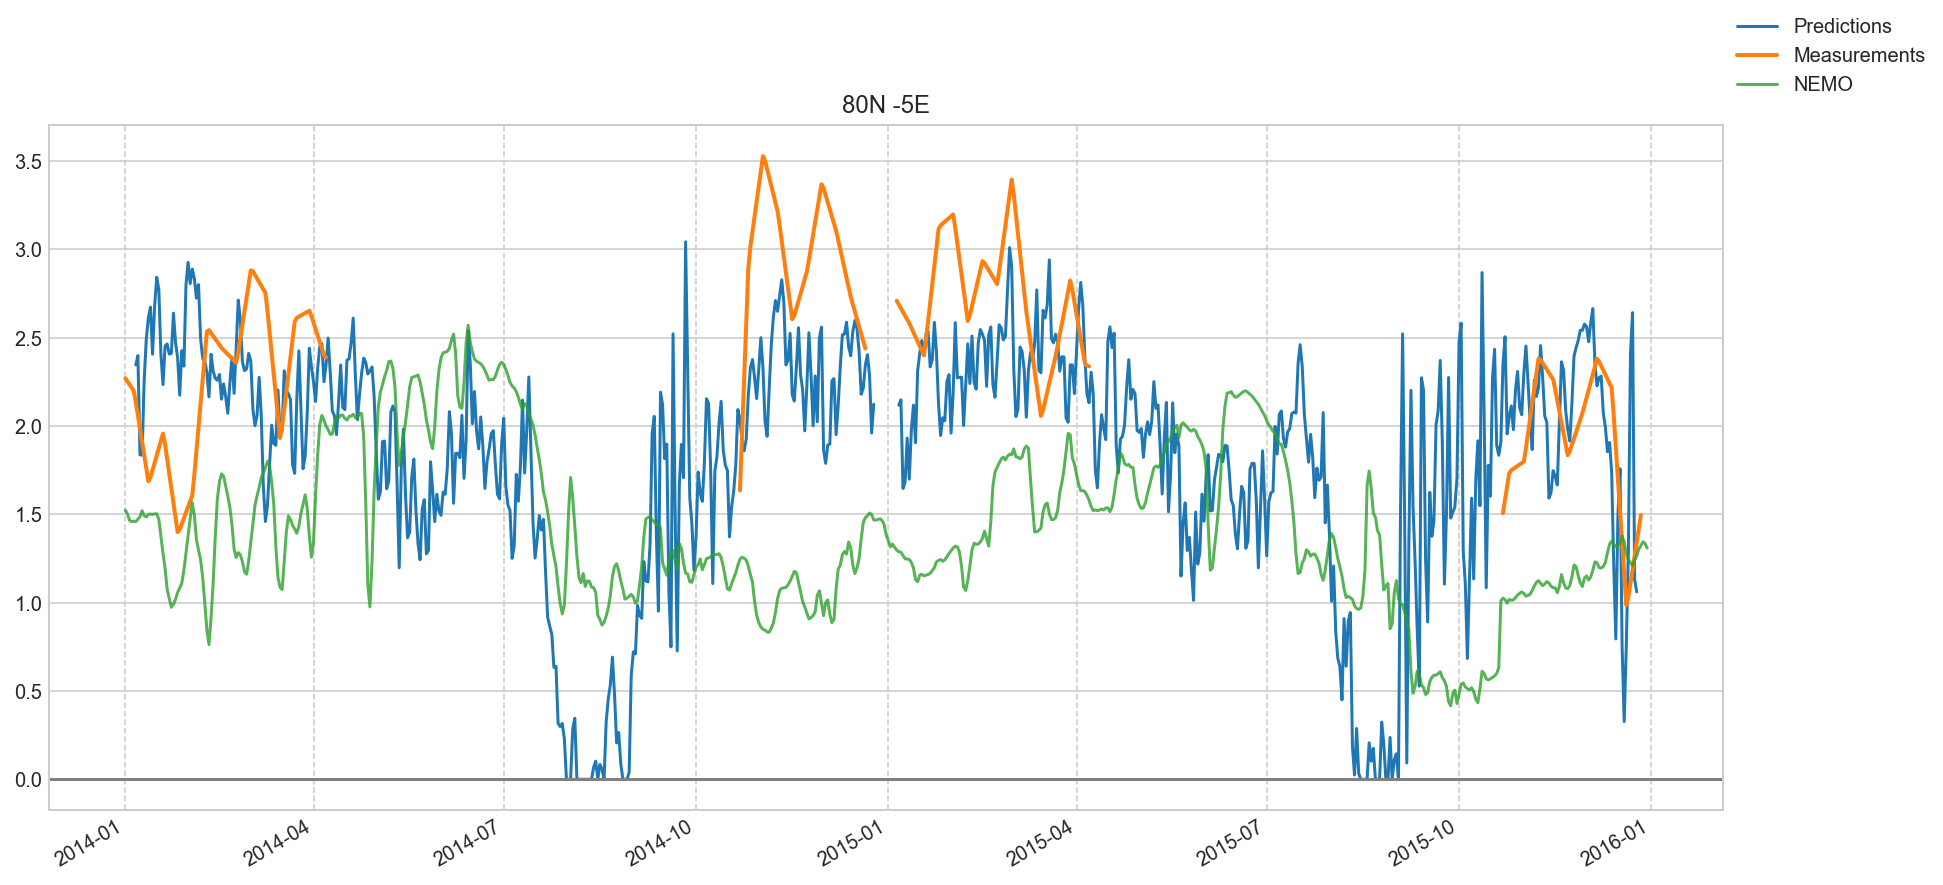

2020-01-21 19:23:20	Loading test and train data...
2020-01-21 19:26:32	Data is loaded
[94.26143794 96.29802488 97.92002062 98.46796289 98.76370425 98.94601534
 99.09779201 99.21388684 99.31439079 99.40095464 99.46183902 99.51296871
 99.56249807 99.59852002 99.63175693 99.6591379  99.68070053 99.70142072
 99.71999797 99.73736612]
[86.78358854 90.37534112 92.44835011 94.01066496 94.77155792 95.25170273
 95.66960686 96.02099996 96.34368797 96.5950023  96.81236188 96.98636165
 97.14706996 97.28171235 97.41192463 97.53204058 97.64498749 97.74244635
 97.83350672 97.91726056]
[91.70196774 94.50769052 95.84187764 96.85063999 97.68883543 98.33150227
 98.79588473 99.11265672 99.35872899 99.56091979 99.73823327 99.78359643
 99.8179805  99.84005713 99.85713159 99.87123744 99.88396907 99.89473978
 99.90453237 99.91383164]
[77.21114275 94.68304412 96.41135568 97.74767647 98.81836062 99.03536819
 99.15081147 99.25208564 99.33499102 99.40667994 99.47635237 99.53904297
 99.59806119 99.65499449 99.71075

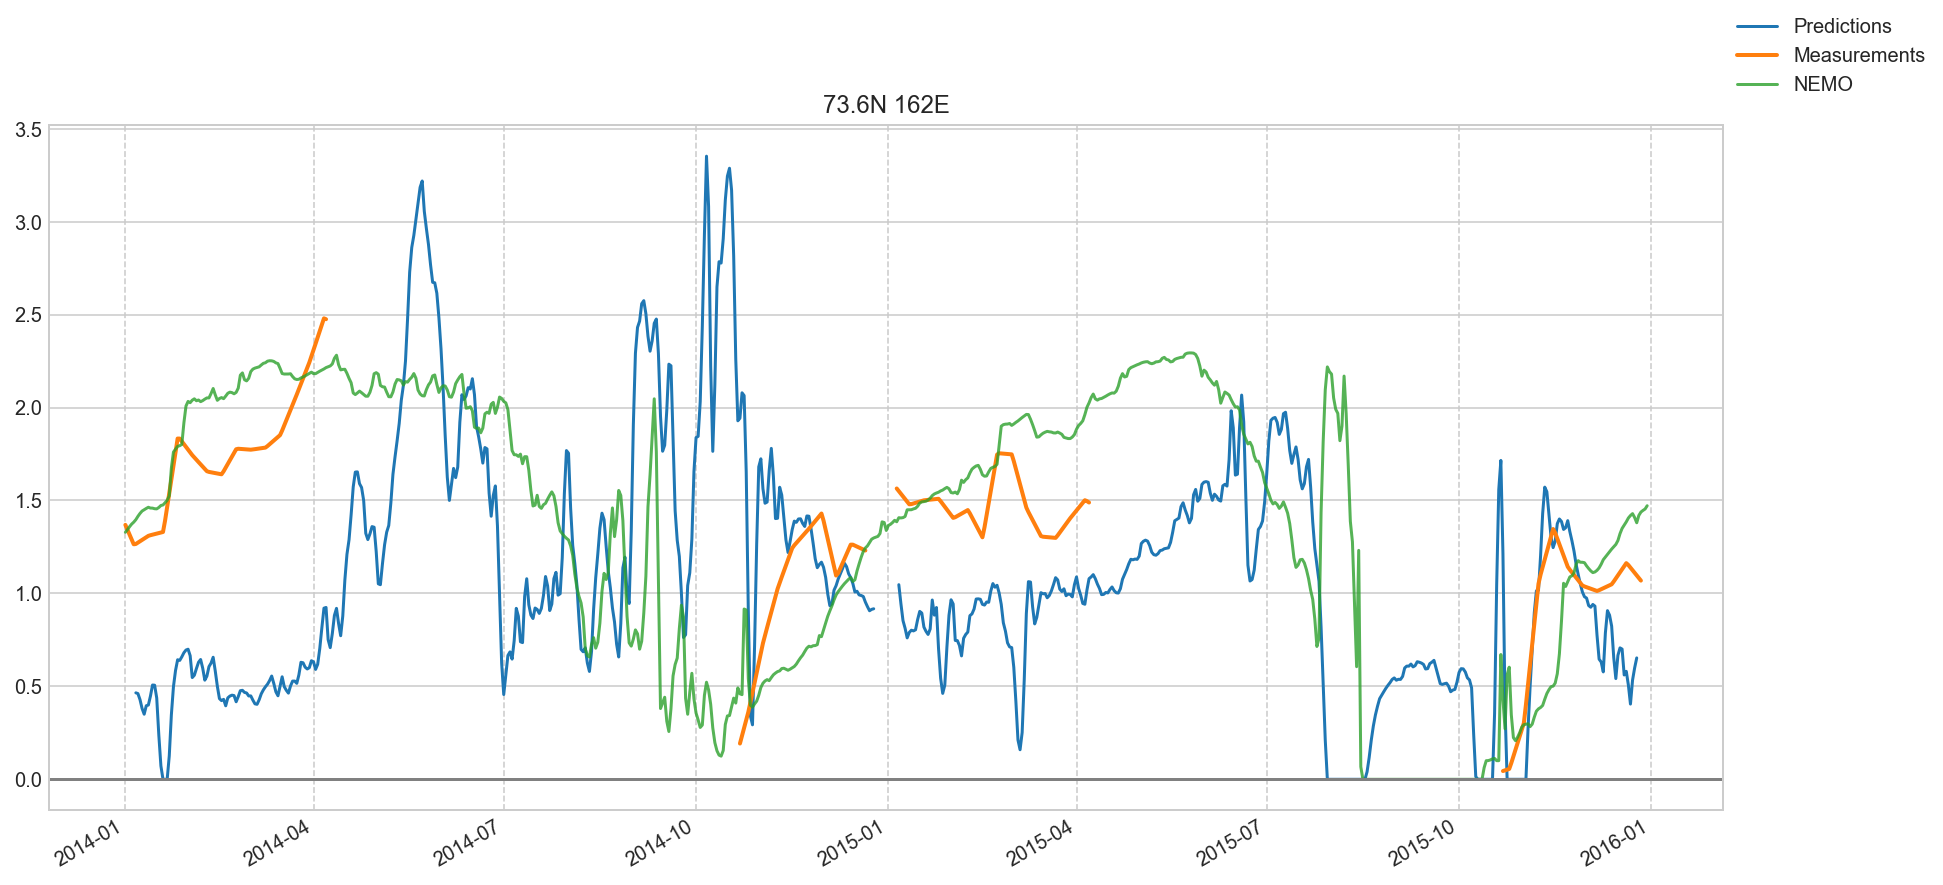

2020-01-21 19:26:48	Loading test and train data...
2020-01-21 19:30:00	Data is loaded
[86.87193108 91.13651618 92.71106687 94.06750251 95.0553463  95.80577537
 96.45520416 96.98543324 97.43658771 97.68190542 97.92311171 98.12388983
 98.27895989 98.42437725 98.56534348 98.67893464 98.76968672 98.84900224
 98.91866579 98.9864106 ]
[96.10306219 97.59473617 98.15372928 98.40908028 98.60701182 98.74021989
 98.84782777 98.94784426 99.02197165 99.08738321 99.14591567 99.18733726
 99.22709433 99.26408308 99.29605391 99.32310141 99.34876964 99.37270579
 99.39466658 99.41498786]
[90.40666265 93.32821301 95.45985041 96.8608256  97.70869233 98.35362767
 98.82417632 99.13924902 99.36951273 99.57719688 99.73513941 99.76795103
 99.78920711 99.80782014 99.82477703 99.84149921 99.85747311 99.87170901
 99.88554316 99.89847019]
[98.67039923 99.29181918 99.594118   99.74046103 99.78540082 99.81312981
 99.83414311 99.85111872 99.86561502 99.87903124 99.89123311 99.90297013
 99.91446288 99.92576819 99.93693

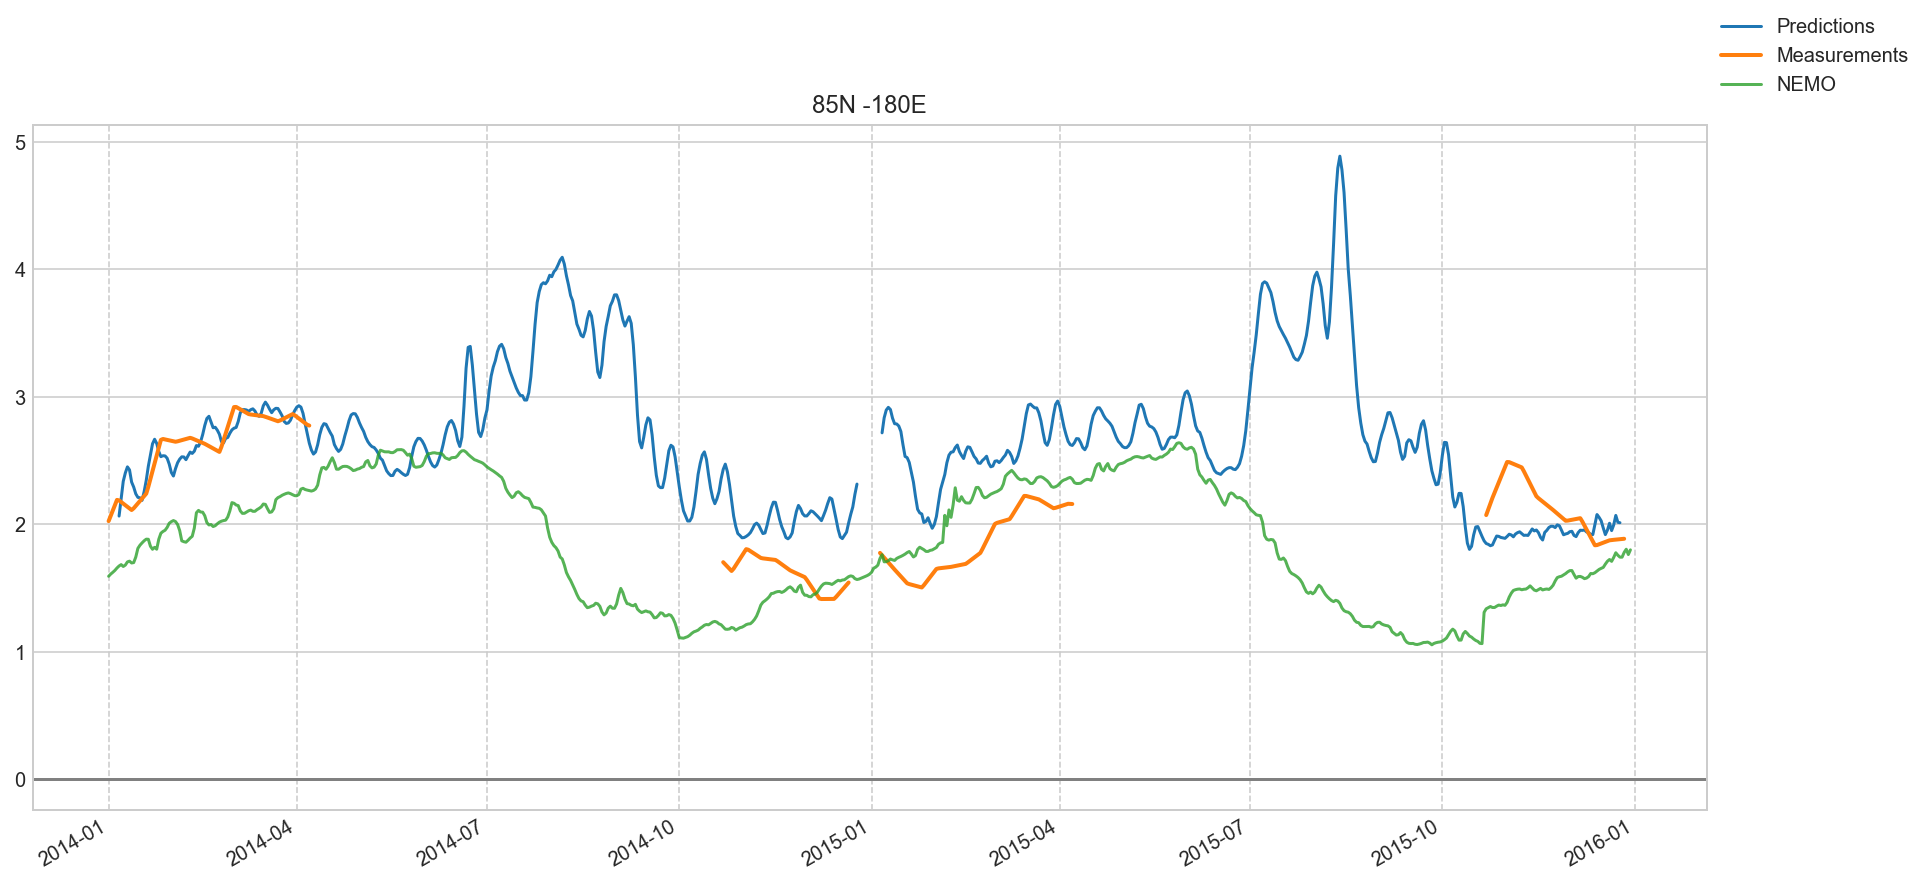

In [14]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=list(range(2014, 2016)),
                  X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw'],
                  #X_vars=['ice_conc','icethic_cea', 'votemper','vosaline'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )
filters = dict(partial_pca=20)

for point in points:
    regress(point, parameters, reg_params, filters)

In [ ]:
plt.imshow(res[10,:,:])

In [14]:
df = pd.read_csv('/Users/drigo/dev/windy/acc.csv')

In [17]:
df.to_csv('/Users/drigo/dev/windy/acc.csv')